# Setup
## Libraries

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

from statsmodels.sandbox.stats.runs import runstest_1samp
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import acf

import os
import re
from scipy import ndimage
import math
import random
import cv2
import skimage
from scipy import stats
import pylab

from PIL import Image, ImageEnhance
from skimage.measure import label, regionprops
from skimage.io import imsave
from skimage.filters import threshold_otsu

# Helper functions

In [57]:
def img_info_to_part_id(imgname, location):
	imgid = int(re.search(r"img(\d+)\.bmp", imgname).group(1))
	if location == "top_left":
		return (imgid - 1) * 4
	elif location == "bottom_left":
		return (imgid - 1) * 4 + 1
	elif location == "top_right":
		return (imgid - 1) * 4 + 2
	elif location == "bottom_right":
		return (imgid - 1) * 4 + 3
	else:
		raise ValueError("Invalid location: {}".format(location))

# example
print(img_info_to_part_id("img01.bmp", "top_left"))
print(img_info_to_part_id("img01.bmp", "bottom_left"))
print(img_info_to_part_id("img01.bmp", "top_right"))
print(img_info_to_part_id("img01.bmp", "bottom_right"))
print()
print(img_info_to_part_id("img02.bmp", "top_left"))
print(img_info_to_part_id("img02.bmp", "bottom_left"))
print(img_info_to_part_id("img02.bmp", "top_right"))
print(img_info_to_part_id("img02.bmp", "bottom_right"))

0
1
2
3

4
5
6
7


In [58]:
def part_id_to_img_info(part_id):
	pid_copy = part_id
	while pid_copy % 4 != 0:
		pid_copy -= 1
	imgnum = pid_copy // 4 +1 
	imgnum = "{:02d}".format(imgnum)

	if part_id % 4 == 0:
		location = "top_left"
	elif part_id % 4 == 1:
		location = "bottom_left"
	elif part_id % 4 == 2:
		location = "top_right"
	elif part_id % 4 == 3:
		location = "bottom_right"
	else:
		raise ValueError("Invalid part ID: {}".format(part_id))

	return imgnum, location

# example
print(part_id_to_img_info(0))
print(part_id_to_img_info(1))
print(part_id_to_img_info(2))
print(part_id_to_img_info(3))
print()
print(part_id_to_img_info(4))
print(part_id_to_img_info(5))
print(part_id_to_img_info(6))
print(part_id_to_img_info(7))

('01', 'top_left')
('01', 'bottom_left')
('01', 'top_right')
('01', 'bottom_right')

('02', 'top_left')
('02', 'bottom_left')
('02', 'top_right')
('02', 'bottom_right')


In [59]:
cartella_immagini = {
	'originals': '../Processed dataset/df/',
	'rot&crop': '../Processed dataset/df new/',
	# Altre associazioni possibili
}

def genera_percorso_immagine(part_id, which_ones="originals",option="seg"):	
	imgnum, location = part_id_to_img_info(part_id)
	real_option = option
	if option=="seg":
		real_option = "segmented"
	else:
		real_option = "labeled"

	nome_immagine = f"img{imgnum}.bmp_{location}_{real_option}.png"
	return os.path.join(cartella_immagini[which_ones], nome_immagine)

# Utilizzo della funzione
print(genera_percorso_immagine(0, "originals"))
print(genera_percorso_immagine(1, "originals"))
print(genera_percorso_immagine(2, "originals"))
print(genera_percorso_immagine(3, "originals"))

../Processed dataset/df/img01.bmp_top_left_segmented.png
../Processed dataset/df/img01.bmp_bottom_left_segmented.png
../Processed dataset/df/img01.bmp_top_right_segmented.png
../Processed dataset/df/img01.bmp_bottom_right_segmented.png


# Old df

In [5]:
# Loading a CSV file into a DataFrame
df = pd.read_csv('../Processed dataset/df/image_statistics.csv')
# Dimension 
df.shape

(1794, 13)

In [5]:
# Display the first k rows of a DataFrame
df.head(10)

Image name  Position Region type  ID  Area [pixels]  Perimeter [pixels]  \
0  img01.bmp  top_left        part   0          39334            3979.892   
1  img01.bmp  top_left        void   1             94              37.556   
2  img01.bmp  top_left        void   2             95              46.142   
3  img01.bmp  top_left        void   3            239              77.527   
4  img01.bmp  top_left        void   4            195              61.420   
5  img01.bmp  top_left        void   5            146              54.770   
6  img01.bmp  top_left        void   6            192              71.835   
7  img01.bmp  top_left        void   7            322              72.770   
8  img01.bmp  top_left        void   8            342              76.184   
9  img01.bmp  top_left        void   9            292              78.912   

   Eccentricity  Orientation [radians]  Solidity  Extent  \
0         0.145                 -1.399     0.775   0.658   
1         0.773                  1.445     0.949   0.696   
2         0.935                 -1.466     0.872   0.565   
3         0.942                 -1.432     0.909   0.569   
4         0.885                  1.545     0.907   0.577   
5         0.883                  0.818     0.912   0.477   
6         0.954                 -1.440     0.881   0.529   
7         0.324                  0.429     0.947   0.610   
8         0.498                  0.893     0.927   0.594   
9         0.904                 -0.973     0.927   0.438   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  \
0                     276.941                     274.023   
1                      14.463                       9.178   
2                      19.647                       6.959   
3                      31.984                      10.699   
4                      24.535                      11.419   
5                      20.885                       9.814   
6                      30.397                       9.124   
7                      22.009                      20.826   
8                      23.752                      20.593   
9                      31.198                      13.312   

   Equivalent Diameter [pixels]  
0                       223.789  
1                        10.940  
2                        10.998  
3                        17.444  
4                        15.757  
5                        13.634  
6                        15.635  
7                        20.248  
8                        20.867  
9                        19.282

## Add part_id and num_voids variables

In [30]:
# Aggiunta di una nuova colonna 'Part_ID' utilizzando la funzione img_info_to_part_id
df['Part_ID'] = df.apply(lambda row: img_info_to_part_id(row['Image name'], row['Position']), axis=1)
# Aggiunta di una nuova colonna 'Num_voids' utilizzando group by
df['Num_voids'] = df.groupby('Part_ID')['ID'].transform('max')

In [9]:
# ho to select numeric variables only
dataNum = df.select_dtypes(include=np.number)

## Df split into parts and voids

In [31]:
# Creazione di df_parts selezionando le righe con "Region type" pari a "part"
df_parts = df[df['Region type'] == 'part']
# Creazione di df_voids selezionando le righe con "Region type" pari a "void"
df_voids = df[df['Region type'] == 'void']

### check

In [33]:
# check
pid = random.randint(0,39)
print(df_parts.loc[df_parts['Part_ID']==pid])
print(df_voids.loc[df_voids['Part_ID'] == pid].shape)

print(f"Global dim check: {df_parts.loc[:,'Num_voids'].sum()+40 == df.shape[0]}")

     Image name      Position Region type  ID  Area [pixels]  \
1039  img06.bmp  bottom_right        part   0          40223   

      Perimeter [pixels]  Eccentricity  Orientation [radians]  Solidity  \
1039            3834.997         0.164                 -1.278     0.785   

      Extent  Major Axis Length [pixels]  Minor Axis Length [pixels]  \
1039   0.747                     278.015                      274.25   

      Equivalent Diameter [pixels]  Part_ID  Num_voids  
1039                       226.304       23         40  
(40, 15)
Global dim check: True


In [17]:
df_parts.head(10)

Image name      Position Region type  ID  Area [pixels]  \
0    img01.bmp      top_left        part   0          39334   
42   img01.bmp   bottom_left        part   0          38974   
85   img01.bmp     top_right        part   0          39176   
132  img01.bmp  bottom_right        part   0          38904   
180  img02.bmp      top_left        part   0          38376   
223  img02.bmp   bottom_left        part   0          38086   
266  img02.bmp     top_right        part   0          37905   
314  img02.bmp  bottom_right        part   0          38740   
359  img03.bmp      top_left        part   0          39202   
403  img03.bmp   bottom_left        part   0          39079   

     Perimeter [pixels]  Eccentricity  Orientation [radians]  Solidity  \
0              3979.892         0.145                 -1.399     0.775   
42             4087.348         0.148                 -1.234     0.767   
85             3988.051         0.163                  1.528     0.780   
132            4011.739         0.161                 -1.186     0.772   
180            4133.306         0.119                 -0.789     0.755   
223            4233.674         0.104                 -0.863     0.750   
266            4290.058         0.052                 -0.869     0.752   
314            4084.335         0.128                 -0.828     0.764   
359            4034.821         0.125                 -1.325     0.774   
403            4049.892         0.135                 -1.164     0.771   

     Extent  Major Axis Length [pixels]  Minor Axis Length [pixels]  \
0     0.658                     276.941                     274.023   
42    0.721                     278.216                     275.169   
85    0.712                     275.773                     272.072   
132   0.670                     276.860                     273.250   
180   0.707                     278.803                     276.832   
223   0.729                     279.073                     277.567   
266   0.723                     277.310                     276.929   
314   0.720                     277.947                     275.666   
359   0.722                     276.453                     274.286   
403   0.714                     277.074                     274.527   

     Equivalent Diameter [pixels]  Part_ID  Num_voids  
0                         223.789        1         41  
42                        222.763        2         42  
85                        223.339        3         46  
132                       222.563        4         47  
180                       221.047        5         42  
223                       220.210        6         42  
266                       219.686        7         47  
314                       222.093        8         44  
359                       223.413        9         43  
403                       223.063       10         43

In [34]:
# save datasets
df_parts.reset_index(drop=True, inplace=True)
df_voids.reset_index(drop=True, inplace=True)

df.to_csv('../Processed dataset/df.csv', index=False)
df_parts.to_csv('../Processed dataset/df_parts.csv', index=False)
df_voids.to_csv('../Processed dataset/df_voids.csv', index=False)

# New df
Where new is because we precisely rotate and crop all the images to bring them into a common base on which then compute the variables.\
So we define here df_new and consequently df_new_parts, df_new_voids.
So that the old df and df_ecc remain for comparison.

## Images reorientation and cut

We tried with using the orientation angle provided in the dataset but it didnt work.\
So we now implement the real code for rotate&crop.
References:
- https://gist.github.com/jdhao/1cb4c8f6561fbdb87859ac28a84b0201
- https://stackoverflow.com/questions/11627362/how-to-straighten-a-rotated-rectangle-area-of-an-image-using-opencv-in-python

In [65]:
def rotate_and_crop(img, rect, verbose=0):
	# get params
	center, size, angle = rect[0], rect[1], rect[2]
	
	if angle > 45:
		angle = angle - 90
	if verbose == 1:
		print(f"Angle inside function is {angle}")
	
	center, size = tuple(map(int, center)), tuple(map(int, size))
	if verbose==1:
		print(rect)
		print(center)
		print(size)
	# get row and col num in img
	height, width = img.shape[0], img.shape[1]
	# rotation matrix
	M = cv2.getRotationMatrix2D(center, angle, 1)
	# apply rotation
	img_rot = cv2.warpAffine(img, M, (width, height))
	# crop it
	img_crop = cv2.getRectSubPix(img_rot, size, center)

	return img_crop, img_rot

In [122]:
def summary_gaussianity(data_points,titolo=""):
	plt.figure(figsize=(8,4))
	plt.subplot(1, 2, 1)
	stats.probplot(data_points,plot=plt)
	plt.subplot(1, 2, 2)
	plt.hist(data_points)
	plt.suptitle(f"{titolo}")
	plt.show()
	shapiro_stat, shapiro_pvalue = stats.shapiro(data_points)
	print(f"({titolo}) P-value of normality: {shapiro_pvalue} - normality (alpha 5%)? {shapiro_pvalue>0.05}")

# https://en.wikipedia.org/wiki/Curvature#In_terms_of_a_general_parametrization
# Calcola la curvatura per una serie di punti
def calculate_curvature(points):
	# Calcola la differenza delle coordinate x e y tra i punti successivi e precedenti
	dx = np.gradient(points[:, 0])
	dy = np.gradient(points[:, 1])

	# Calcola la seconda differenza delle coordinate x e y
	d2x = np.gradient(dx)
	d2y = np.gradient(dy)

	# Calcola la curvatura utilizzando la formula di curvatura
	curvature = (d2x * dy - d2y * dx) / (dx**2 + dy**2)**1.5

	return curvature

Angle inside function is 1.5911402702331543
((130.5316162109375, 128.8619842529297), (228.57850646972656, 228.1619873046875), 1.5911402702331543)
(130, 128)
(228, 228)


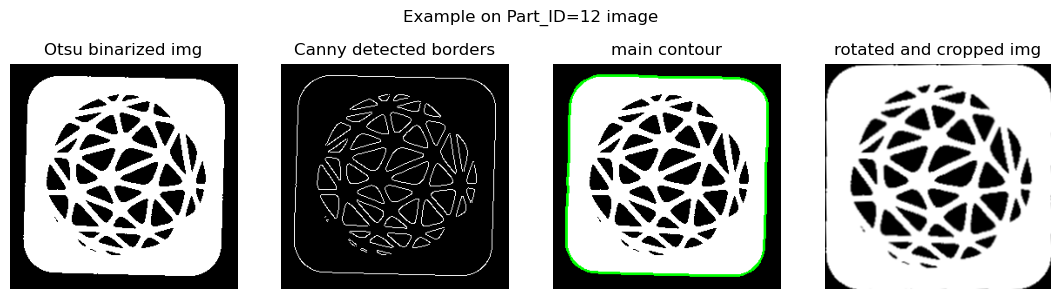

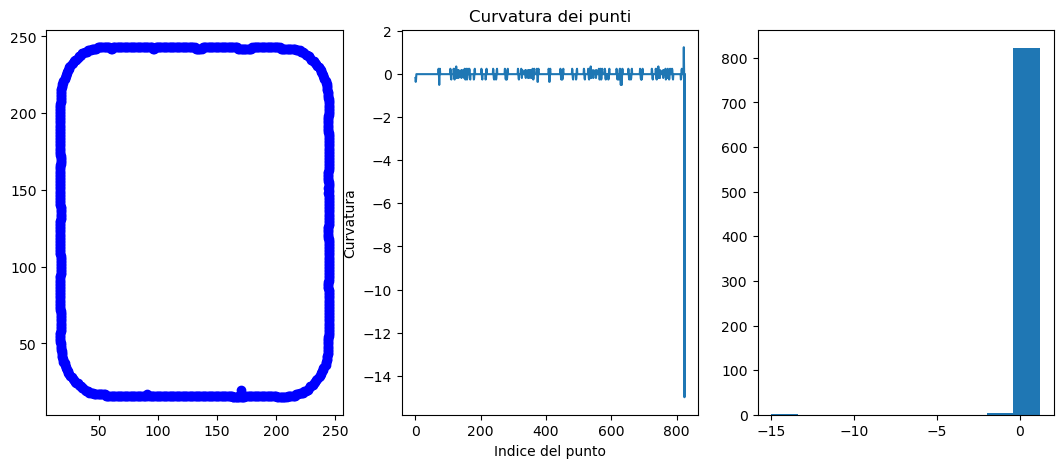

[[164  15]
 [163  16]
 [162  16]
 ...
 [165  15]
 [170  20]
 [164  15]]


In [289]:
# example about how it works
curvatures = np.zeros(40)

part_id = random.randint(0,39)
part_id = 12
img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

# Converti l'immagine in scala di grigi
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(11, 3))

# Applica la binarizzazione Otsu
(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# (T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.subplot(1, 4, 1)
plt.imshow(threshInv, cmap='gray')
plt.title('Otsu binarized img')
plt.axis('off')

# Apply the Canny filter to detect edges
edged = cv2.Canny(threshInv, 30, 200)
plt.subplot(1, 4, 2)
plt.imshow(edged, cmap='gray')
plt.title('Canny detected borders')
plt.axis('off')
plt.tight_layout()
# plt.show()

# Find the contours
contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

# Select the biggest contour
largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

img_with_contours = img.copy()
# plt.figure(figsize=(8, 8))
plt.subplot(1, 4, 3)
cv2.drawContours(img_with_contours, largest_contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
plt.title('main contour')
plt.axis('off')

# crop the pictures following the biggest contour
for i, contours in enumerate (largest_contours):
	# if i % 2 == 0:
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		# print(f"Angle here is {rect[2]}")
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=1)
		# print(f"Angle in df was {df.loc[part_id, 'Orientation [radians]']} radians, ie {math.degrees(df.loc[part_id, 'Orientation [radians]'])} degrees")
		# cropped_images.append(cropped_image)                
		# cropped_filename = os.path.splitext(filename)[0] + "_crp{}.jpg".format(i+1)

		plt.subplot(1, 4, 4)
		plt.imshow(cropped_image)
		plt.title(f"rotated and cropped img")
		plt.axis('off')
		plt.suptitle(f"Example on Part_ID={part_id} image")
		plt.tight_layout()
		plt.show()

		edged = cv2.Canny(rot_image, 30, 200)
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
		contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE )
		# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE )
		largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

# reconnect end with begin points
contours_points = np.append(largest_contours[0][:, 0], [[170,20],largest_contours[0][:, 0][0]], axis=0)
# contours_points = np.append(largest_contours[0][:, 0], [largest_contours[0][:, 0][0]], axis=0)
# print(contours_points)

x_coords = [point[0] for point in contours_points]
y_coords = [point[1] for point in contours_points]
plt.figure(figsize=(13, 5))
plt.subplot(1, 3, 1)
plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b')

plt.subplot(1, 3, 2)
curvature = calculate_curvature(contours_points)
plt.plot(curvature)
plt.xlabel('Indice del punto')
plt.ylabel('Curvatura')
plt.title('Curvatura dei punti')
plt.subplot(1, 3, 3)
plt.hist(curvature)
plt.show()
print(contours_points)

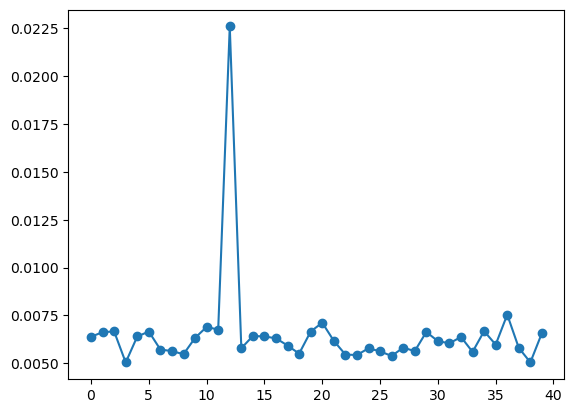

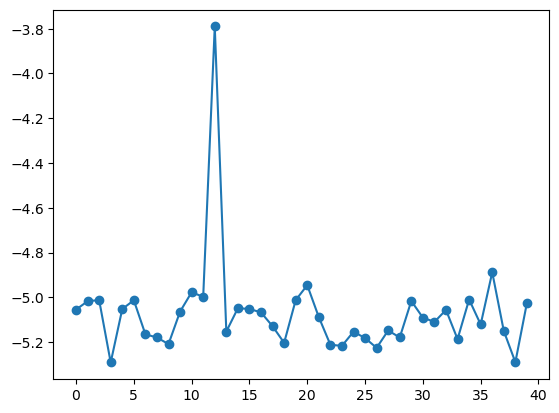

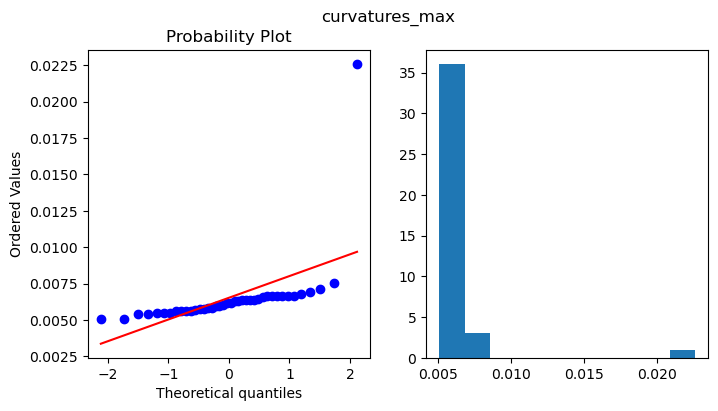

(curvatures_max) P-value of normality: 2.281947634324988e-12 - normality (alpha 5%)? False


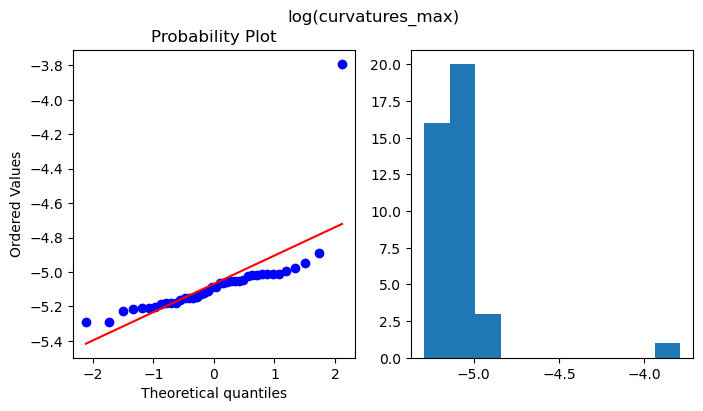

(log(curvatures_max)) P-value of normality: 3.1462737970500143e-10 - normality (alpha 5%)? False


In [298]:
# example about how it works
curvatures_max = np.zeros(40)
curvatures_min = np.zeros(40)

# part_id = random.randint(0,40)
for part_id in range(40):

	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
	# (T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)
	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	img_with_contours = img.copy()

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		# if i % 2 == 0:
			rect = cv2.minAreaRect(contours)
			box = cv2.boxPoints(rect)
			box = np.int0(box)
			# print(f"Angle here is {rect[2]}")
			cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)
			# print(f"Angle in df was {df.loc[part_id, 'Orientation [radians]']} radians, ie {math.degrees(df.loc[part_id, 'Orientation [radians]'])} degrees")
			# cropped_images.append(cropped_image)                
			# cropped_filename = os.path.splitext(filename)[0] + "_crp{}.jpg".format(i+1)

			edged = cv2.Canny(rot_image, 30, 200)
			# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)
			# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
			contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE )
			# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE )
			largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# reconnect end with begin points
	contours_points = np.append(largest_contours[0][:, 0], [largest_contours[0][:, 0][0]], axis=0)
	# try to emulate a defected piece
	# if part_id==12:
	# 	contours_points = np.append(largest_contours[0][:, 0], [[170,10],largest_contours[0][:, 0][0]], axis=0)
	# else:
	# 	contours_points = np.append(largest_contours[0][:, 0], [largest_contours[0][:, 0][0]], axis=0)

	x_coords = [point[0] for point in contours_points]
	y_coords = [point[1] for point in contours_points]
	curvature = calculate_curvature(contours_points)

	# curvatures_max[part_id] = np.max(np.abs(curvature))+np.mean(curvature)
	curvatures_max[part_id] = np.mean((curvature))
	curvatures_min[part_id] = np.min(curvature)

plt.plot(curvatures_max,'o-')
plt.show()

plt.plot(np.log(curvatures_max),'o-')
plt.show()

summary_gaussianity(curvatures_max,"curvatures_max")
summary_gaussianity(np.log(curvatures_max),"log(curvatures_max)")
# summary_gaussianity(curvatures_min,"curvatures_min")

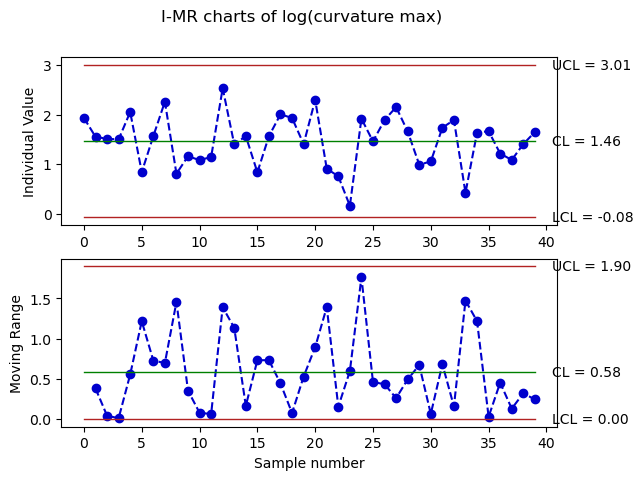

In [228]:
import qda
data = pd.DataFrame(np.log(curvatures_max),columns=["log(curvature max)"])
data_IMR = qda.ControlCharts.IMR(data,'log(curvature max)')

In [132]:
np.corrcoef(np.log(curvatures_max),df_new_parts["Perimeter [pixels]"])

array([[ 1.        , -0.03958841],
       [-0.03958841,  1.        ]])

c:\Users\feder\anaconda3\envs\qda\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


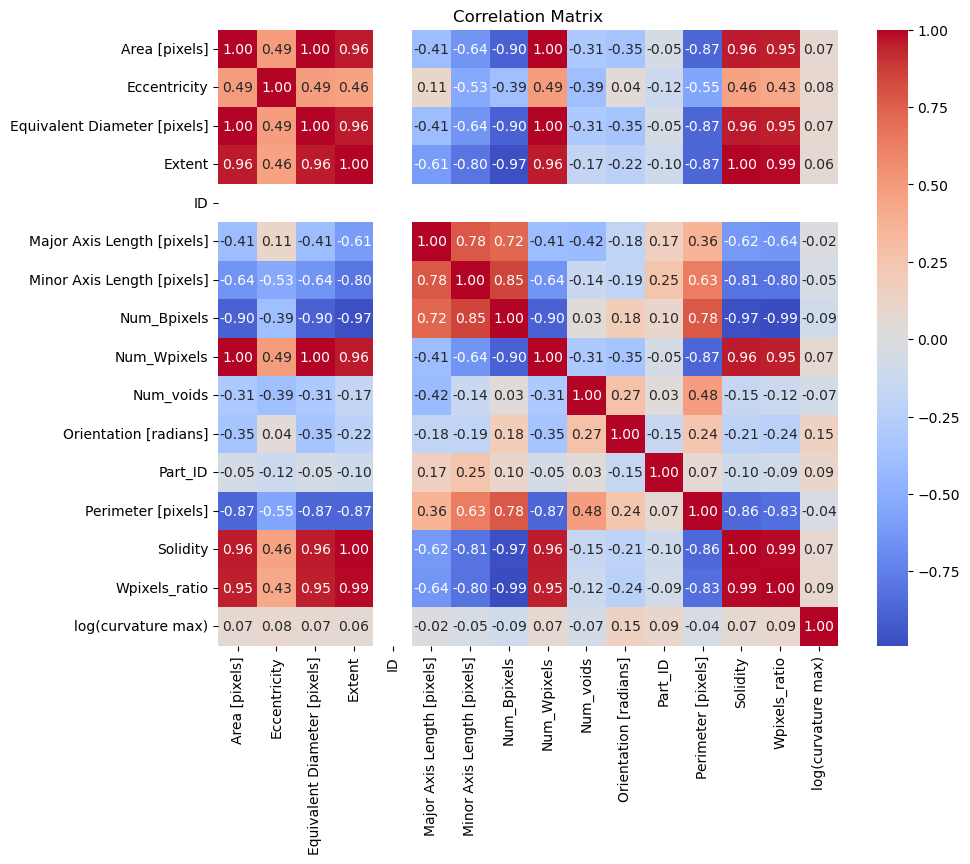

In [131]:
import seaborn as sns

dataset = df_new_parts
dataset["log(curvature max)"] = np.log(curvatures_max)
data_std = (dataset - dataset.mean()) / dataset.std()
cor_matrix_std = data_std.corr()
cor_matrix_std

plt.figure(figsize=(10, 8))
sns.heatmap(cor_matrix_std, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Curvature test stuff

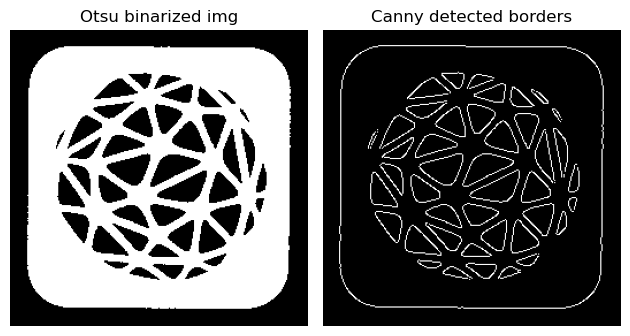

Angle here is 0.48146581649780273
Angle inside function is 0.48146581649780273
Angle in df was 0.818 radians, ie 46.867947641701335 degrees


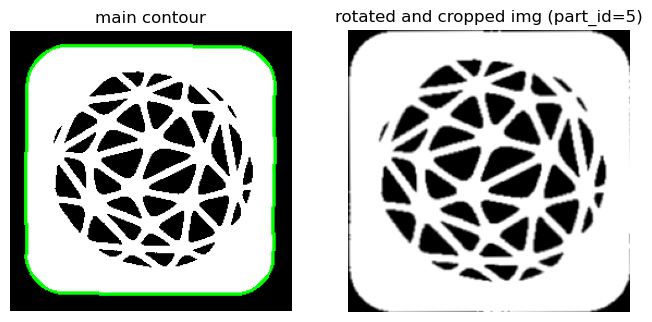

In [30]:
# example about how it works
part_id = random.randint(0,40)
# part_id
img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

# Converti l'immagine in scala di grigi
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.figure(figsize=(10, 10))
# plt.subplot(1, 3, 1)
# plt.imshow(gray, cmap='gray')
# plt.title('grayscale img')
# plt.axis('off')

# Applica il filtro bilaterale per ridurre il rumore
# blurred_img = cv2.bilateralFilter(gray, 10, 100, 100)
# plt.subplot(1, 2, 2)
# plt.imshow(blurred_img, cmap='gray')
# plt.title('blurred img')
# plt.axis('off')
# maybe blurred not really needed
# decide it in the img input to the next function (choose gray or blurred_img)

# Applica la binarizzazione Otsu
(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
# (T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
plt.subplot(1, 2, 1)
plt.imshow(threshInv, cmap='gray')
plt.title('Otsu binarized img')
plt.axis('off')

# Apply the Canny filter to detect edges
edged = cv2.Canny(threshInv, 30, 200)
plt.subplot(1, 2, 2)
plt.imshow(edged, cmap='gray')
plt.title('Canny detected borders')
plt.axis('off')
plt.tight_layout()
plt.show()

# Find the contours
contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

# Select the biggest contour
largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

img_with_contours = img.copy()
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
cv2.drawContours(img_with_contours, largest_contours, -1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(img_with_contours, cv2.COLOR_BGR2RGB))
plt.title('main contour')
plt.axis('off')

# crop the pictures following the biggest contour
for i, contours in enumerate (largest_contours):
	# if i % 2 == 0:
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		print(f"Angle here is {rect[2]}")
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=1)
		print(f"Angle in df was {df.loc[part_id, 'Orientation [radians]']} radians, ie {math.degrees(df.loc[part_id, 'Orientation [radians]'])} degrees")
		# cropped_images.append(cropped_image)                
		# cropped_filename = os.path.splitext(filename)[0] + "_crp{}.jpg".format(i+1)

		plt.subplot(1, 2, 2)
		plt.imshow(cropped_image)
		plt.title(f"rotated and cropped img (part_id={part_id})")
		plt.axis('off')
		plt.show()

## Saving new df

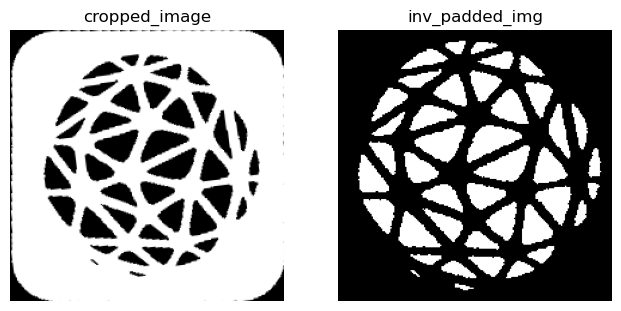

<Figure size 800x800 with 0 Axes>

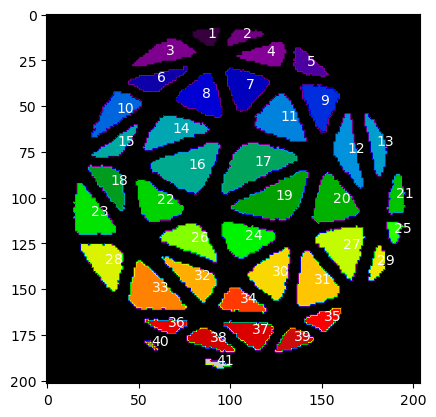

Nvoids from props: 41
Rows added now: 41
Nvoids in df old were: 41



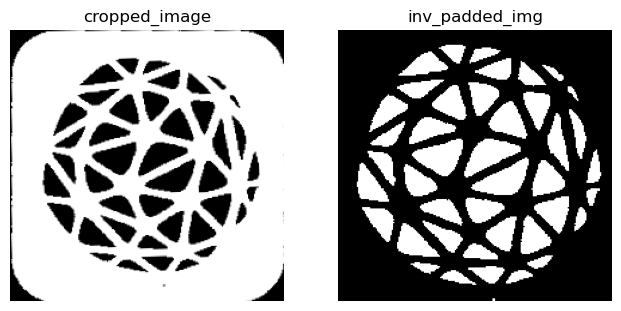

<Figure size 800x800 with 0 Axes>

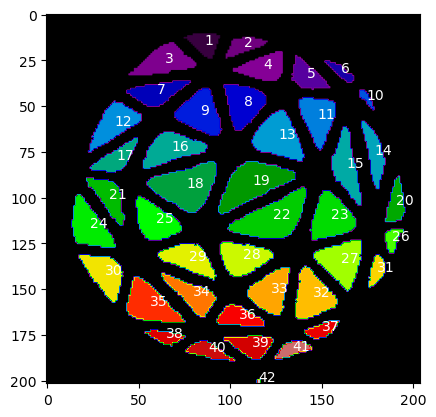

Nvoids from props: 42
Rows added now: 42
Nvoids in df old were: 42



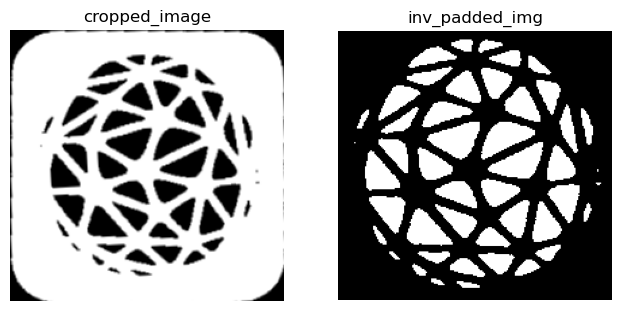

<Figure size 800x800 with 0 Axes>

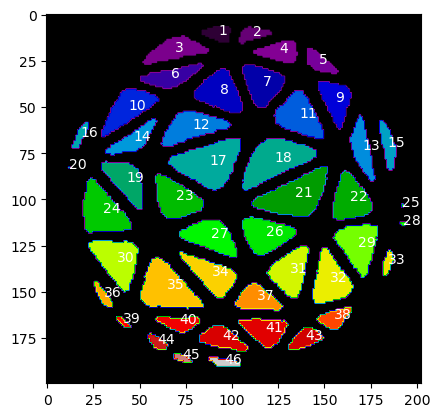

Nvoids from props: 46
Rows added now: 46
Nvoids in df old were: 46



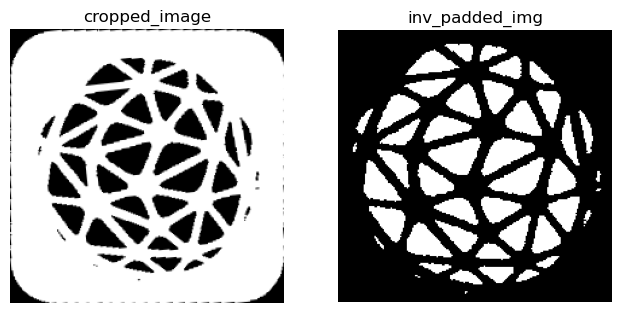

<Figure size 800x800 with 0 Axes>

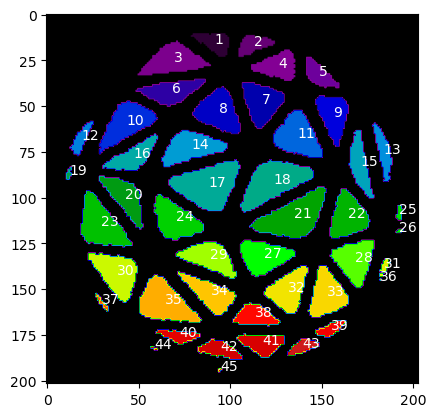

Nvoids from props: 45
Rows added now: 45
Nvoids in df old were: 47



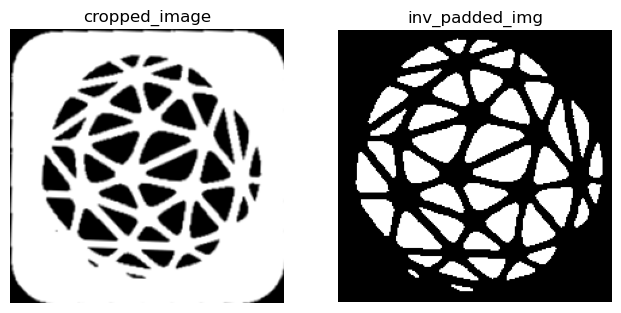

<Figure size 800x800 with 0 Axes>

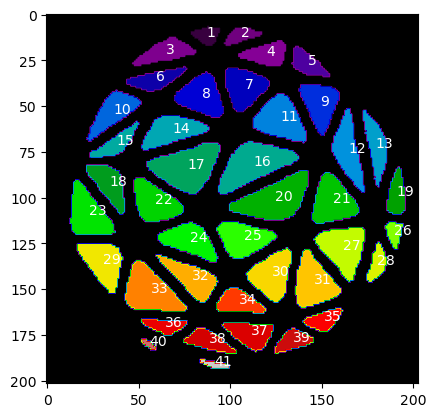

Nvoids from props: 41
Rows added now: 41
Nvoids in df old were: 42



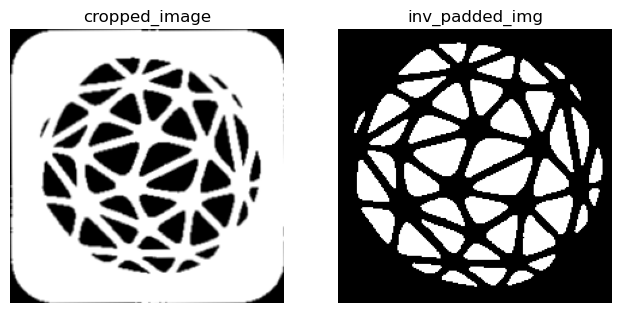

<Figure size 800x800 with 0 Axes>

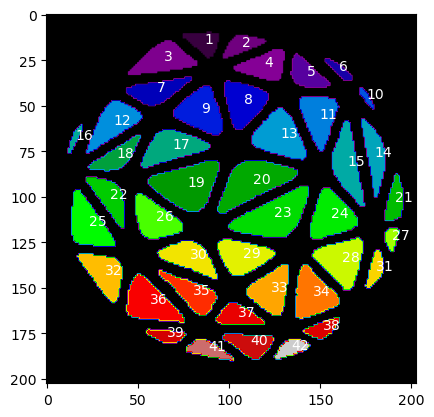

Nvoids from props: 42
Rows added now: 42
Nvoids in df old were: 42



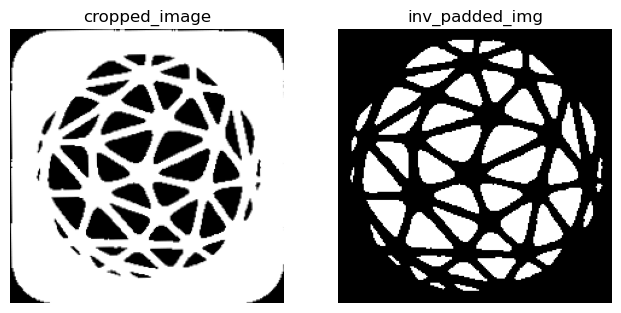

<Figure size 800x800 with 0 Axes>

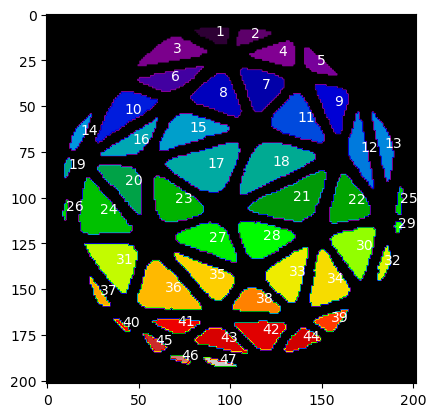

Nvoids from props: 47
Rows added now: 47
Nvoids in df old were: 47



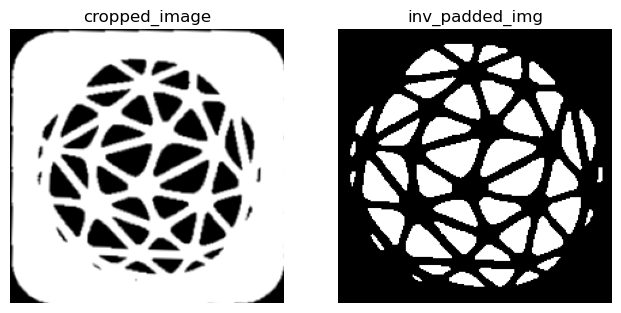

<Figure size 800x800 with 0 Axes>

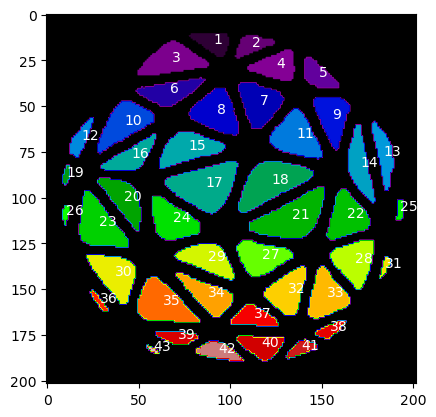

Nvoids from props: 43
Rows added now: 43
Nvoids in df old were: 44



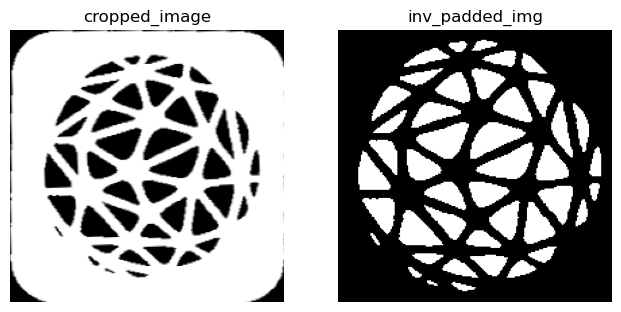

<Figure size 800x800 with 0 Axes>

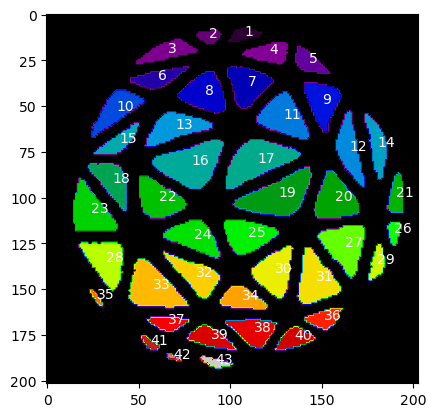

Nvoids from props: 43
Rows added now: 43
Nvoids in df old were: 43



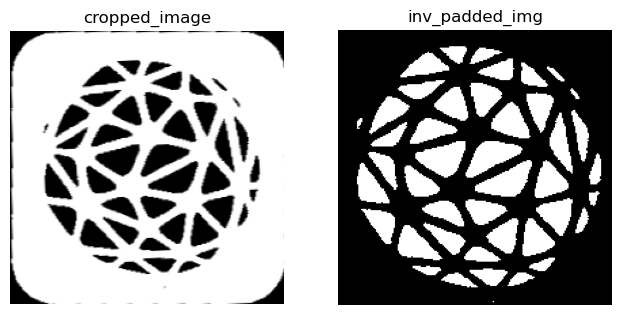

<Figure size 800x800 with 0 Axes>

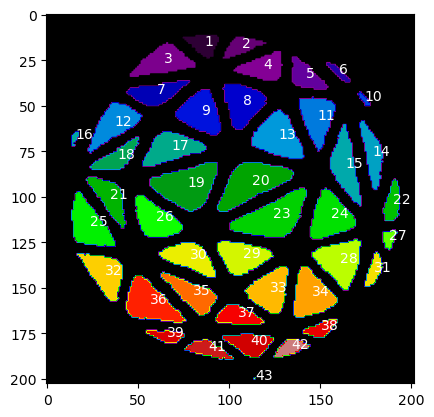

Nvoids from props: 43
Rows added now: 43
Nvoids in df old were: 43



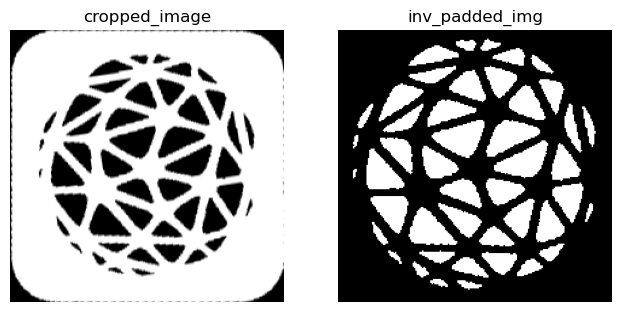

<Figure size 800x800 with 0 Axes>

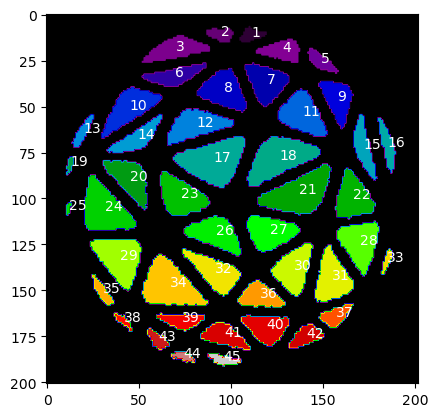

Nvoids from props: 45
Rows added now: 45
Nvoids in df old were: 45



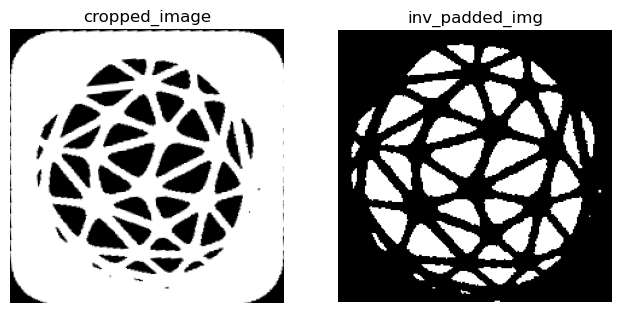

<Figure size 800x800 with 0 Axes>

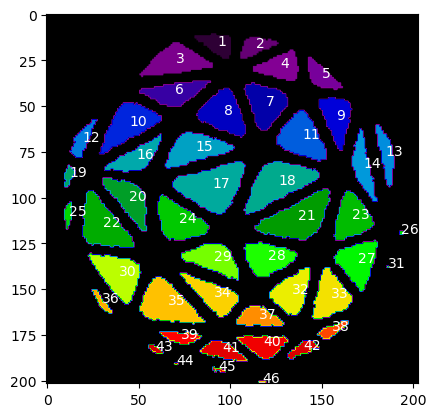

Nvoids from props: 46
Rows added now: 46
Nvoids in df old were: 46



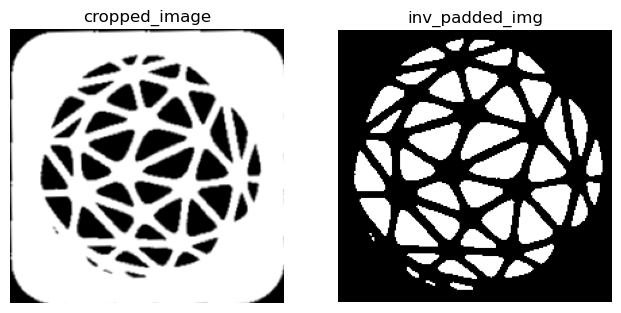

<Figure size 800x800 with 0 Axes>

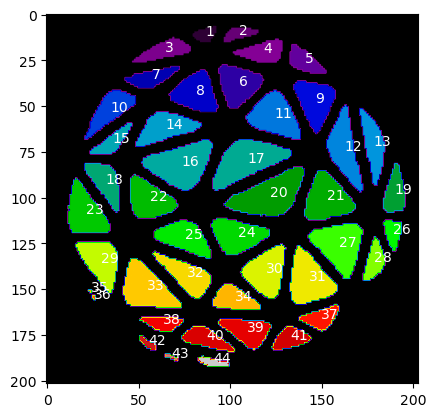

Nvoids from props: 44
Rows added now: 44
Nvoids in df old were: 44



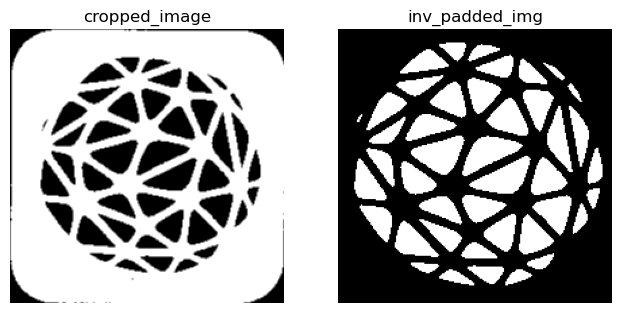

<Figure size 800x800 with 0 Axes>

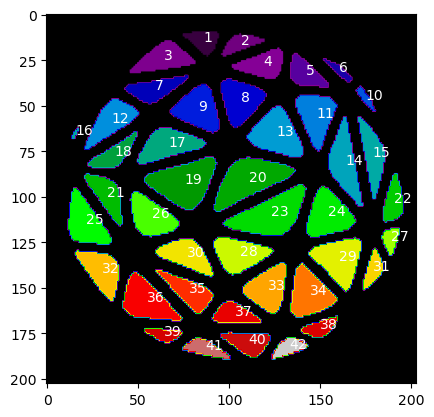

Nvoids from props: 42
Rows added now: 42
Nvoids in df old were: 44



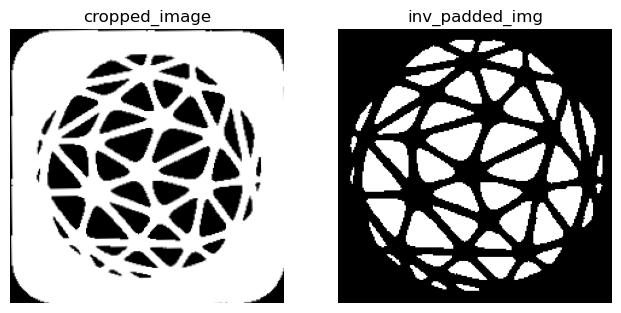

<Figure size 800x800 with 0 Axes>

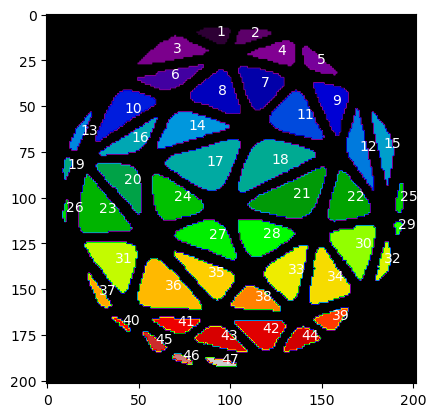

Nvoids from props: 47
Rows added now: 47
Nvoids in df old were: 47



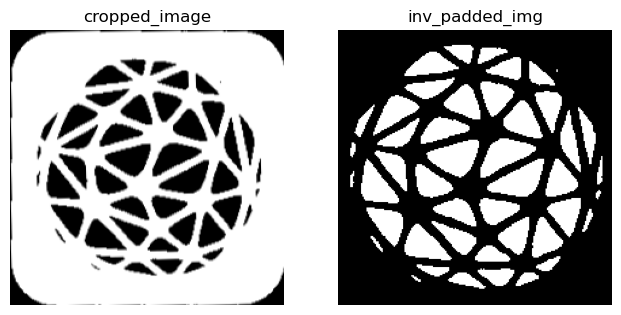

<Figure size 800x800 with 0 Axes>

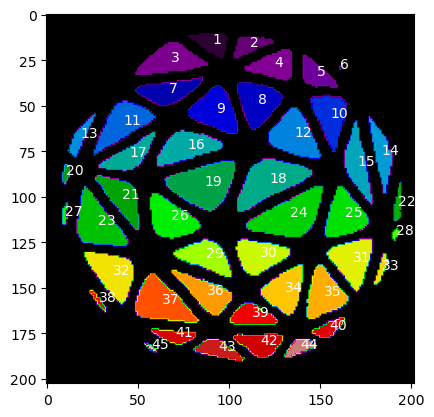

Nvoids from props: 45
Rows added now: 45
Nvoids in df old were: 45



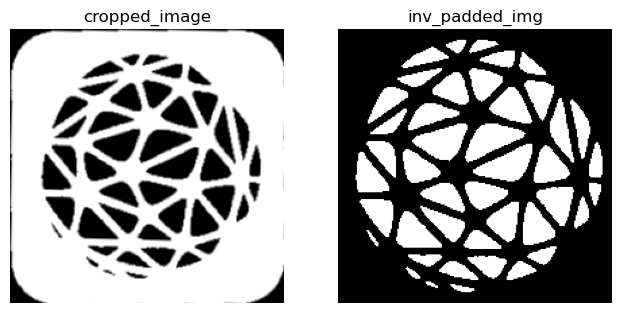

<Figure size 800x800 with 0 Axes>

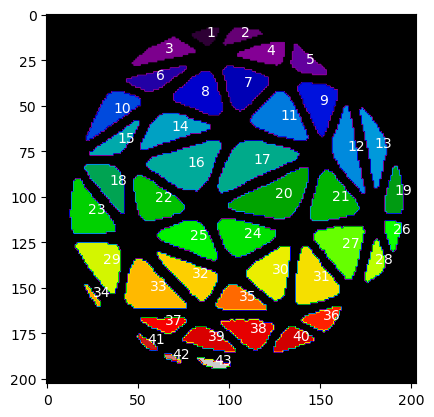

Nvoids from props: 43
Rows added now: 43
Nvoids in df old were: 43



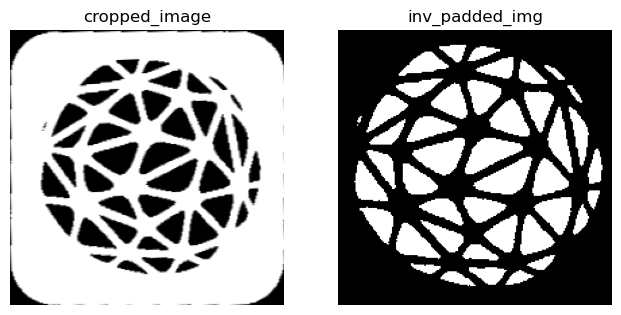

<Figure size 800x800 with 0 Axes>

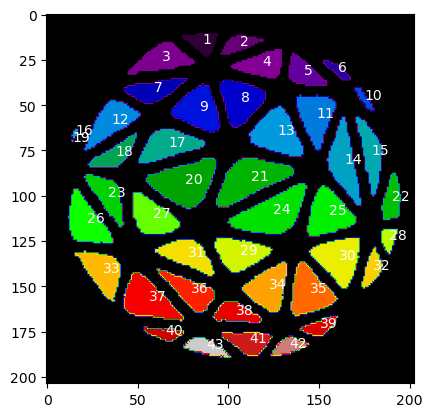

Nvoids from props: 43
Rows added now: 43
Nvoids in df old were: 43



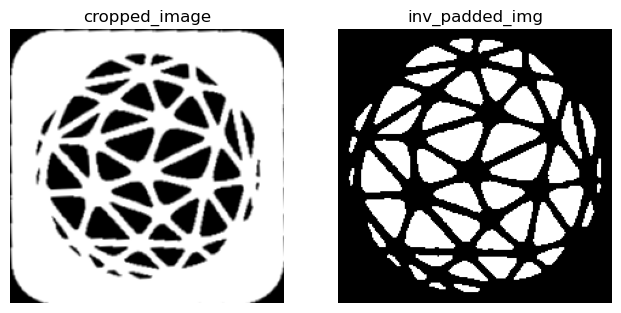

<Figure size 800x800 with 0 Axes>

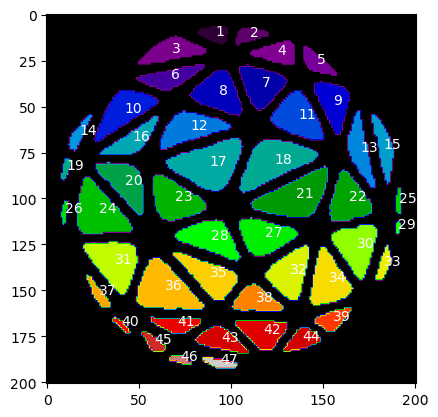

Nvoids from props: 47
Rows added now: 47
Nvoids in df old were: 47



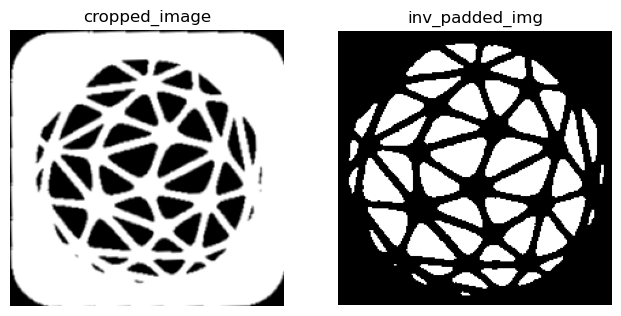

<Figure size 800x800 with 0 Axes>

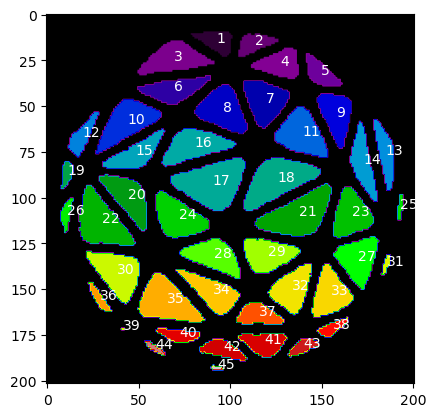

Nvoids from props: 45
Rows added now: 45
Nvoids in df old were: 46



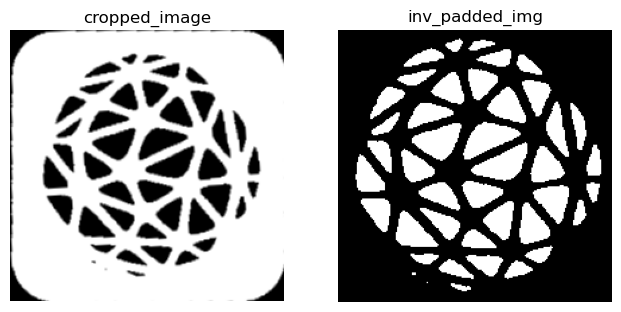

<Figure size 800x800 with 0 Axes>

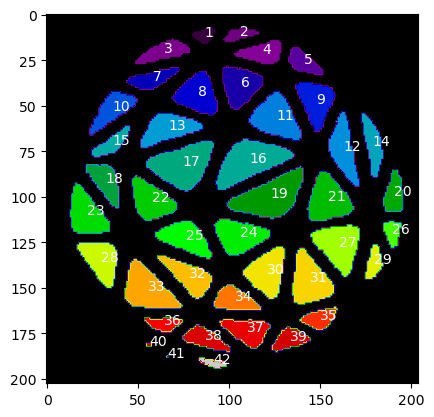

Nvoids from props: 42
Rows added now: 42
Nvoids in df old were: 42



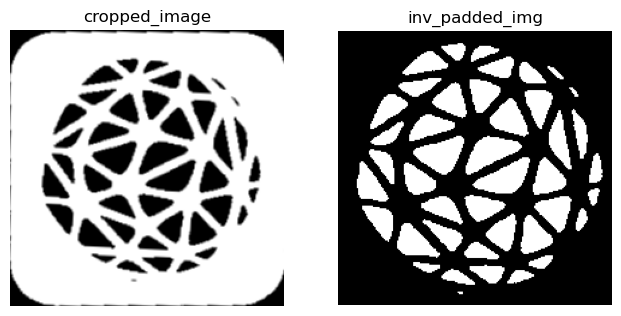

<Figure size 800x800 with 0 Axes>

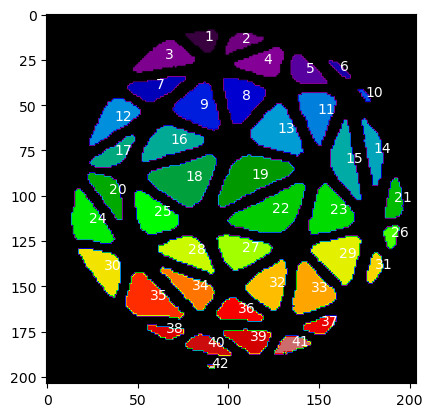

Nvoids from props: 42
Rows added now: 42
Nvoids in df old were: 42



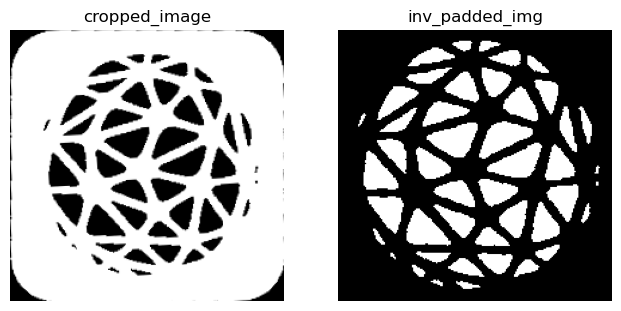

<Figure size 800x800 with 0 Axes>

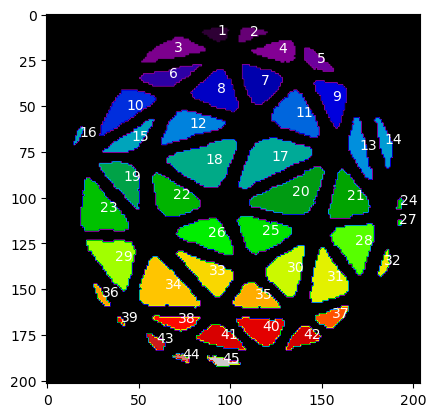

Nvoids from props: 45
Rows added now: 45
Nvoids in df old were: 45



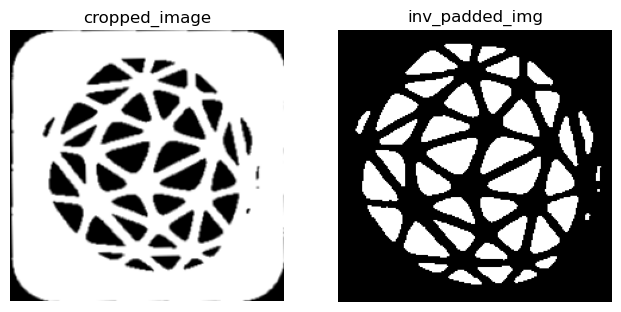

<Figure size 800x800 with 0 Axes>

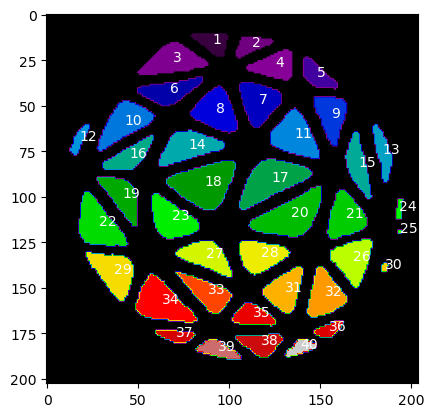

Nvoids from props: 40
Rows added now: 40
Nvoids in df old were: 40



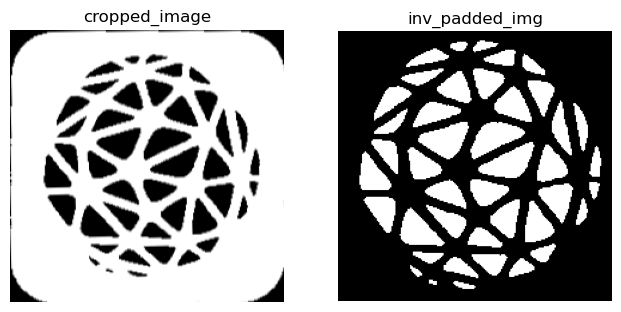

<Figure size 800x800 with 0 Axes>

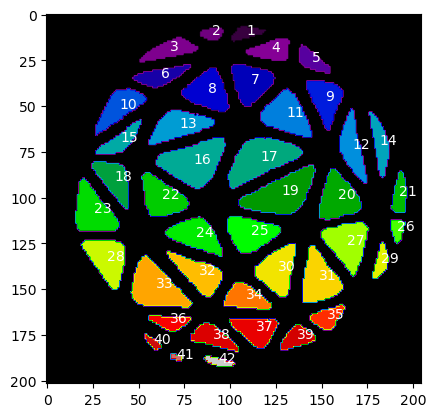

Nvoids from props: 42
Rows added now: 42
Nvoids in df old were: 42



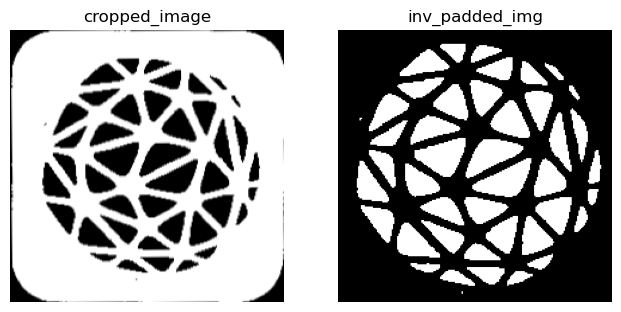

<Figure size 800x800 with 0 Axes>

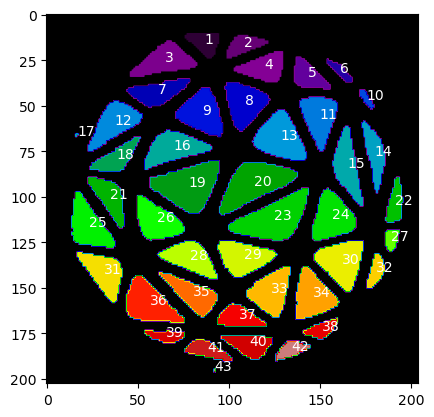

Nvoids from props: 43
Rows added now: 43
Nvoids in df old were: 43



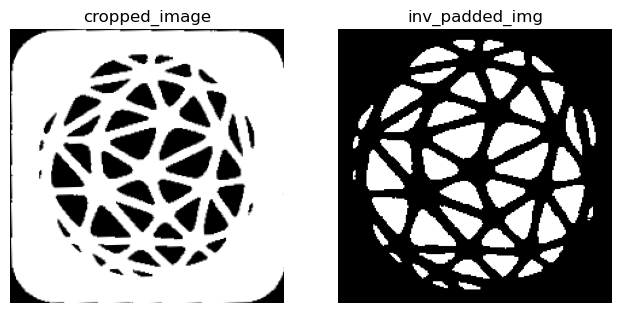

<Figure size 800x800 with 0 Axes>

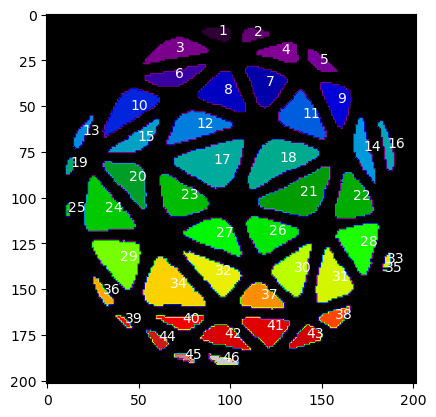

Nvoids from props: 46
Rows added now: 46
Nvoids in df old were: 46



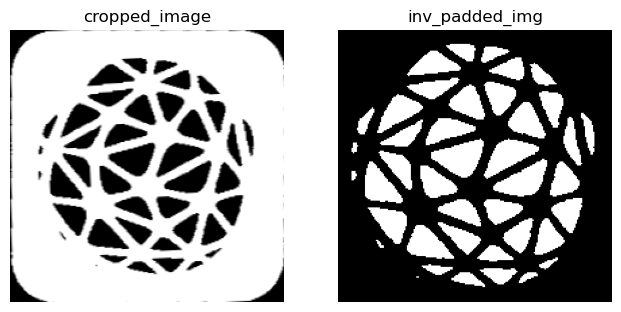

<Figure size 800x800 with 0 Axes>

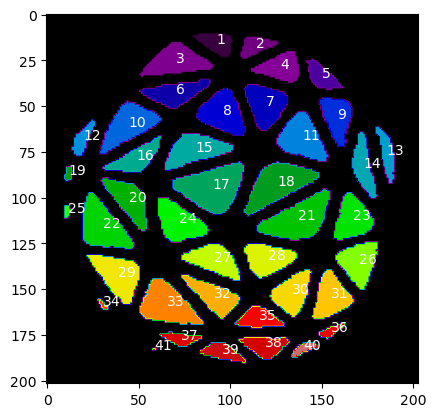

Nvoids from props: 41
Rows added now: 41
Nvoids in df old were: 41



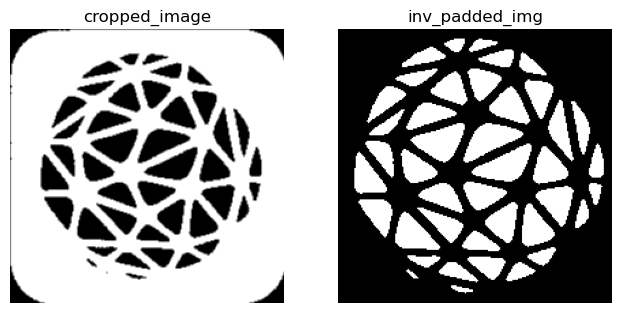

<Figure size 800x800 with 0 Axes>

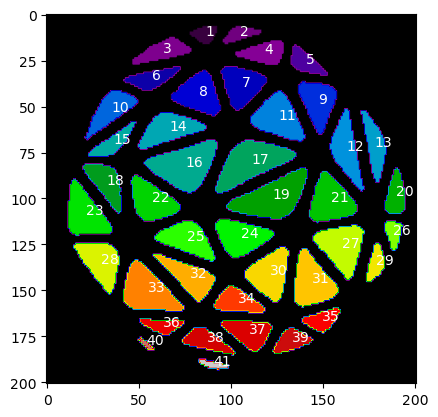

Nvoids from props: 41
Rows added now: 41
Nvoids in df old were: 42



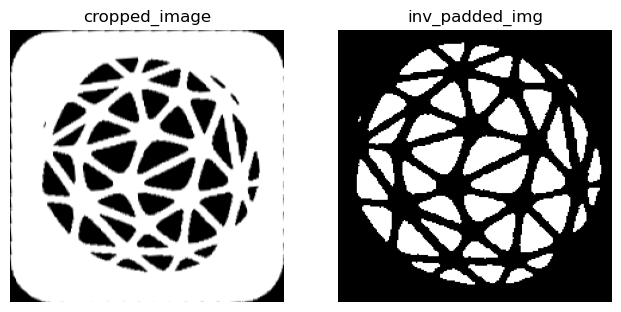

<Figure size 800x800 with 0 Axes>

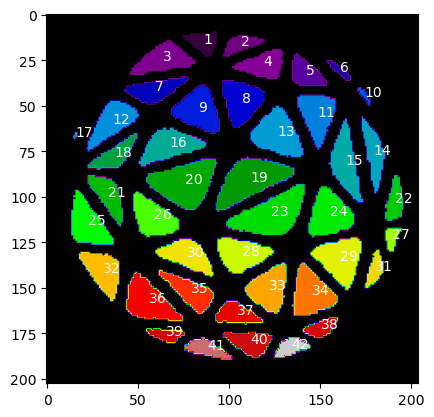

Nvoids from props: 42
Rows added now: 42
Nvoids in df old were: 42



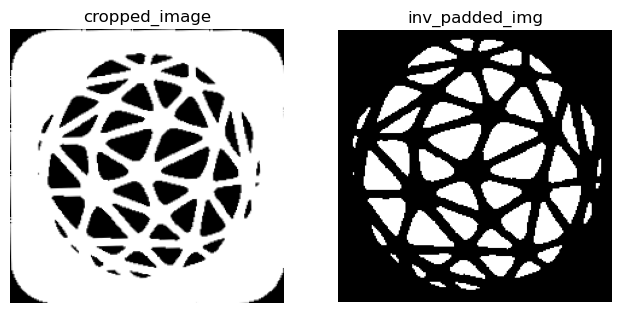

<Figure size 800x800 with 0 Axes>

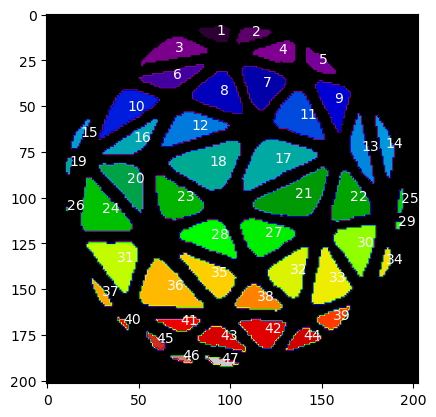

Nvoids from props: 47
Rows added now: 47
Nvoids in df old were: 47



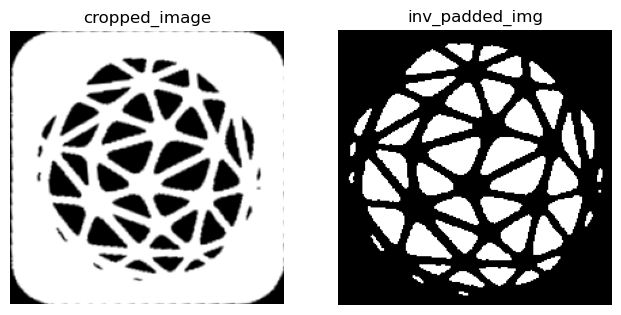

<Figure size 800x800 with 0 Axes>

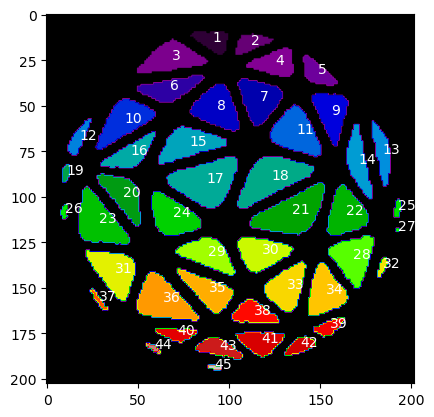

Nvoids from props: 45
Rows added now: 45
Nvoids in df old were: 45



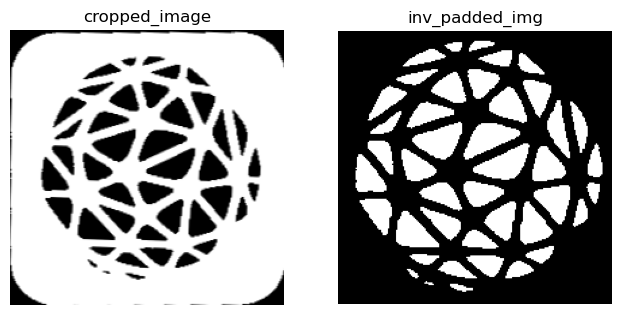

<Figure size 800x800 with 0 Axes>

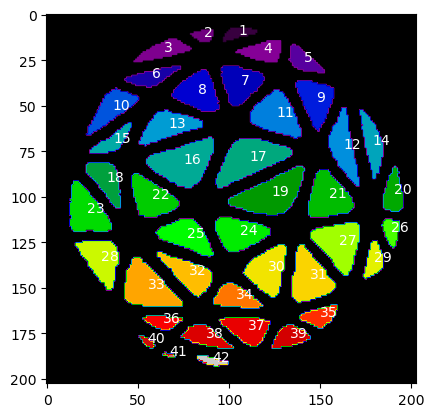

Nvoids from props: 42
Rows added now: 42
Nvoids in df old were: 42



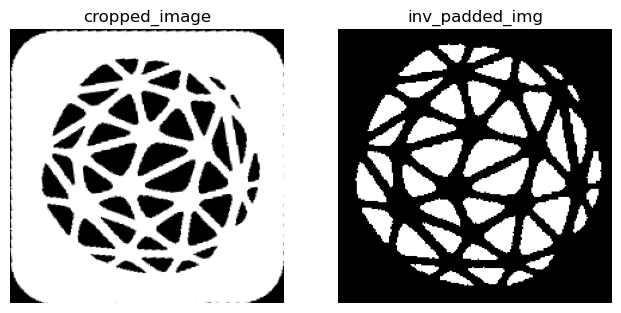

<Figure size 800x800 with 0 Axes>

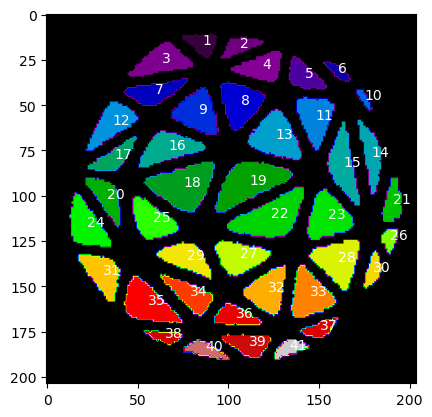

Nvoids from props: 41
Rows added now: 41
Nvoids in df old were: 41



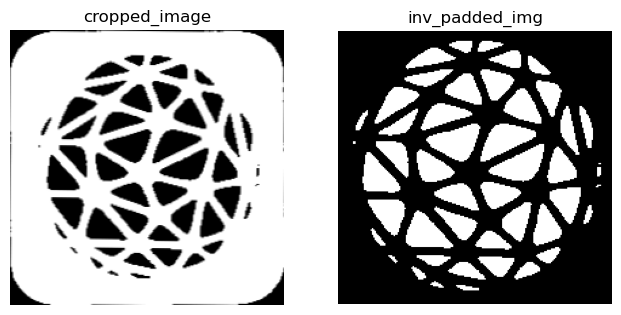

<Figure size 800x800 with 0 Axes>

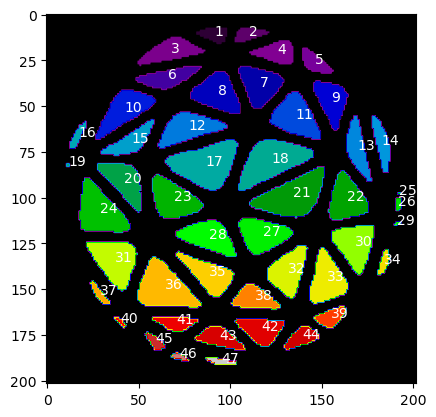

Nvoids from props: 47
Rows added now: 47
Nvoids in df old were: 47



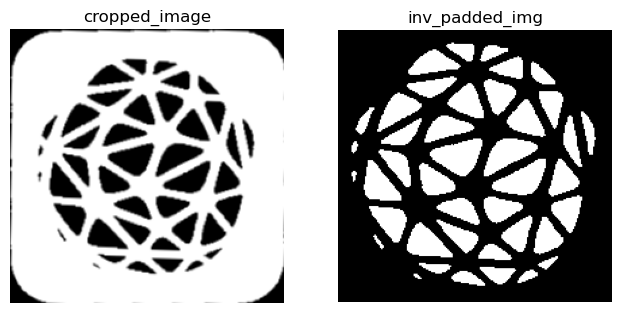

<Figure size 800x800 with 0 Axes>

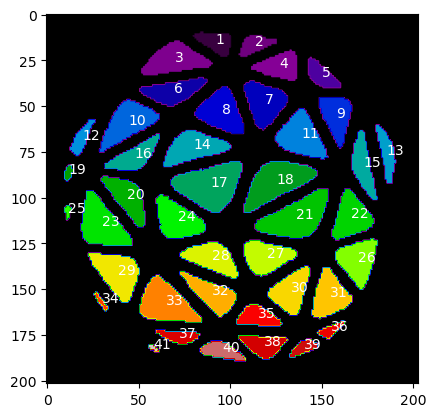

Nvoids from props: 41
Rows added now: 41
Nvoids in df old were: 41



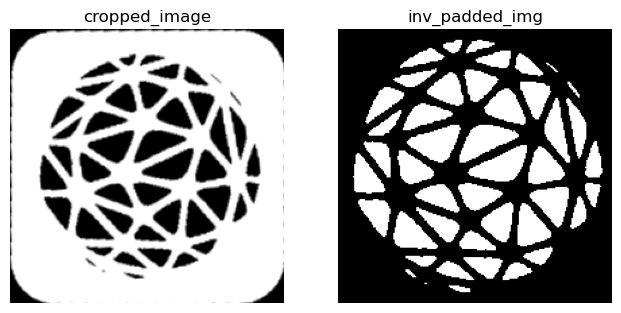

<Figure size 800x800 with 0 Axes>

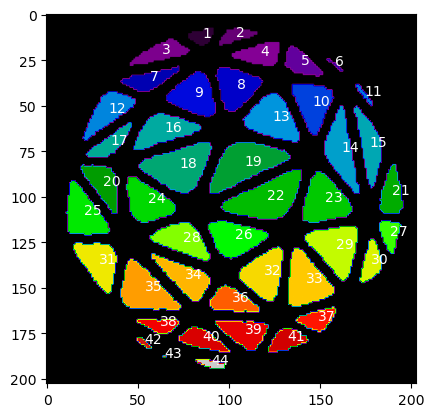

Nvoids from props: 44
Rows added now: 44
Nvoids in df old were: 44



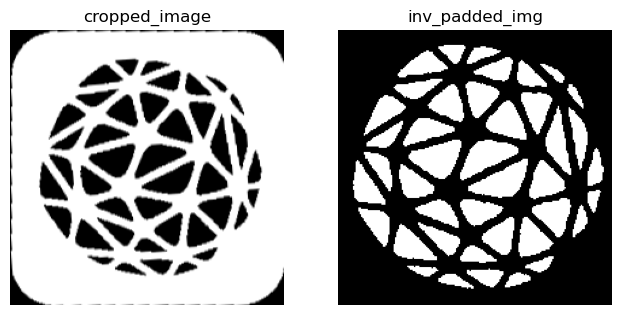

<Figure size 800x800 with 0 Axes>

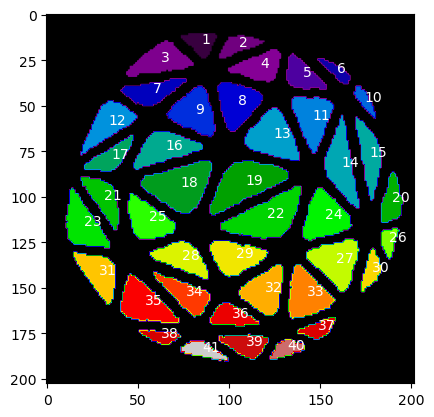

Nvoids from props: 41
Rows added now: 41
Nvoids in df old were: 41



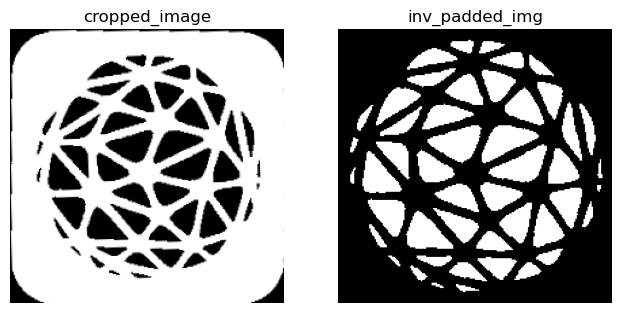

<Figure size 800x800 with 0 Axes>

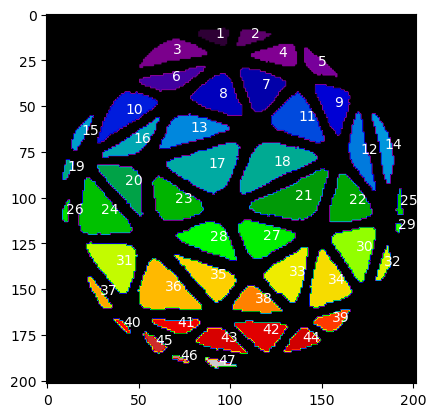

Nvoids from props: 47
Rows added now: 47
Nvoids in df old were: 47



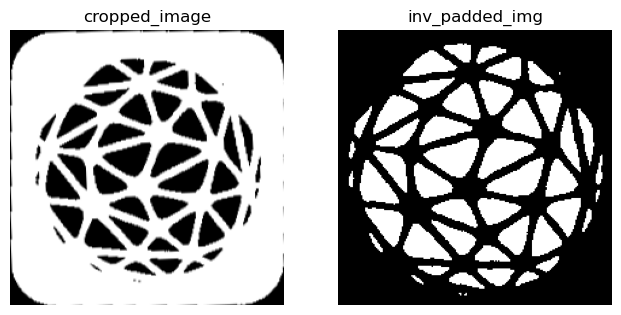

<Figure size 800x800 with 0 Axes>

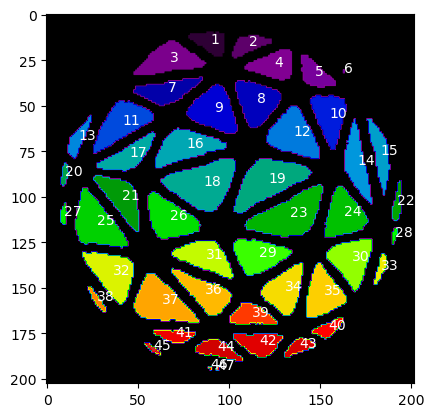

Nvoids from props: 47
Rows added now: 47
Nvoids in df old were: 47



In [647]:
output_folder = "../Processed dataset/df new/"
statistics = []

for part_id in range(0,40):
	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
	# Applica il filtro bilaterale per ridurre il rumore
	blurred_img = cv2.bilateralFilter(gray, 10, 100, 100)
	# maybe blurred not really needed
	# decide it in the img input to the next function (choose gray or blurred_img)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)

	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		rect = cv2.minAreaRect(contours)
		box = cv2.boxPoints(rect)
		box = np.int0(box)
		cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)

		img_info = part_id_to_img_info(part_id)
		filename = f"img{img_info[0]}.bmp_{img_info[1]}_segmented.png"
		cv2.imwrite(os.path.join(output_folder, filename), cropped_image) 

		# print(type(cropped_image))
		plt.figure(figsize=(12, 12))
		plt.subplot(1,3,1)
		plt.imshow(cropped_image)
		plt.axis('off')
		plt.title("cropped_image")

		# img_pil = Image.fromarray(cropped_image, 'RGB')
		# img_pil = img_pil.convert('L')
		# print(type(img_pil))
		# plt.imshow(img_pil,cmap="gray")
		# plt.axis('off')
		# plt.show()

		# gray = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
		# (T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
		# labeled_segmented_image = label(threshInv)
	
		image = Image.open(os.path.join(output_folder, filename))
		# Convert the image to grayscale
		image = image.convert('L')
		# # Increase the contrast
		enhancer = ImageEnhance.Contrast(image)
		image = enhancer.enhance(100)
		# width, height = image.size
		# image = image.crop((0,0,width,height))
		image = np.array(image)
		# plt.imshow(image, cmap='gray')
		# plt.axis('off')  # Nasconde gli assi
		# plt.show()
		otsu_thresh = threshold_otsu(image)
		image = image > otsu_thresh

		# Convert the boolean image to an 8-bit unsigned integer image
		# img = (threshInv.astype(np.uint8) * 255)
		img = (image.astype(np.uint8) * 255)
		# Use regionprops to get properties of the region
		part_props = regionprops(img)[0]  # Get the first (and only) region
		# Crop the image with margin around the bounding box
		minr, minc, maxr, maxc = part_props.bbox
		# print(part_props.bbox)
		minr_crop = max(minr + 12, 0)
		minc_crop = max(minc + 12, 0)
		maxr_crop = min(maxr - 12, img.shape[0])
		maxc_crop = min(maxc - 12, img.shape[1])
		padded_img = img[minr_crop:maxr_crop, minc_crop:maxc_crop]
		
		# Invert the padded image
		inv_padded_img = 255 - padded_img
		plt.subplot(1,3,2)
		plt.imshow(inv_padded_img,cmap="gray")
		plt.axis('off')
		plt.title("inv_padded_img")

		# Apply labeling
		labels = label(inv_padded_img, background=0)
		# props_voids = regionprops(labels)
		# Find the biggest region
		# biggest_region = max(props_voids, key=lambda region: region.area)
		# Set the pixels in the biggest region to 0
		# labels[labels == biggest_region.label] = 0
		# Repeat labeling
		# labels = label(labels, background=0)
		props_voids = regionprops(labels)
		# Create a figure and axes
		plt.figure(figsize=(8, 8))
		fig, ax = plt.subplots()
		# Display the image
		ax.imshow(labels, cmap='nipy_spectral')
		# Annotate label numbers

		for region in regionprops(labels):
			# Get the coordinates of the centroid
			y, x = region.centroid
			# Annotate the label number at the centroid
			ax.text(x, y, str(region.label), color='white')
		# Save the labeled image  		
		labeled_filename = f"img{img_info[0]}.bmp_{img_info[1]}_labeled.png"
		labeled_output_path = os.path.join(output_folder, labeled_filename)
		plt.savefig(labeled_output_path)
		# Close the figure to free up memory
		plt.show()

		
		# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
		statistics.append({
			"Image name": f"img{img_info[0]}.bmp",
			"Position": img_info[1],
			"Region type": "part",
			"ID": 0,
			"Area [pixels]": round(part_props.area, 3),
			"Perimeter [pixels]": round(part_props.perimeter, 3),
			"Eccentricity": round(part_props.eccentricity, 3),
			"Orientation [radians]": round(part_props.orientation, 3),
			"Solidity": round(part_props.solidity, 3),
			"Extent": round(part_props.extent, 3),
			"Major Axis Length [pixels]": round(part_props.major_axis_length, 3),
			"Minor Axis Length [pixels]": round(part_props.minor_axis_length, 3),
			"Equivalent Diameter [pixels]": round(part_props.equivalent_diameter, 3),
			"Part_ID": part_id,
			"Num_voids": len(props_voids)
		})

		old_size = len(statistics)
		# print(f"Old size: {len(statistics)}")

		# Loop over each void
		for i, prop in enumerate(props_voids, start=1):
			# For each statistic in regionprops, create a row with Image name, Position, Region type, ID, and each metric
			statistics.append({
				"Image name": f"img{img_info[0]}.bmp",
				"Position": img_info[1],
				"Region type": "void",
				"ID": i,
				"Area [pixels]": round(prop.area, 3),
				"Perimeter [pixels]": round(prop.perimeter, 3),
				"Eccentricity": round(prop.eccentricity, 3),
				"Orientation [radians]": round(prop.orientation, 3),
				"Solidity": round(prop.solidity, 3),
				"Extent": round(prop.extent, 3),
				"Major Axis Length [pixels]": round(prop.major_axis_length, 3),
				"Minor Axis Length [pixels]": round(prop.minor_axis_length, 3),
				"Equivalent Diameter [pixels]": round(prop.equivalent_diameter, 3),
				"Part_ID": part_id,
				"Num_voids": len(props_voids)
			})

		print(f"Nvoids from props: {len(props_voids)}")
		print(f"Rows added now: {len(statistics)-old_size}")
		print(f"Nvoids in df old were: {df_parts.iloc[part_id]['Num_voids']}\n")
		if (len(statistics)-old_size) != len(props_voids):
			break

# Convert the list of dictionaries to a DataFrame
statistics_df = pd.DataFrame(statistics)
# Export the DataFrame to a CSV file in the output_folder
output_file = os.path.join(output_folder, "image_statistics.csv")
statistics_df.to_csv(output_file, index=False)


# Loading precisely df and new_df
Already available frome the previous code: df, df_parts, df_voids.\
Now here we load df_new, df_new_parts, df_new_voids.

In [648]:
# save
# df_new = pd.read_csv('../Processed dataset/df new/image_statistics.csv')
# df_new_parts = df_new[df_new['Region type'] == 'part']
# df_new_voids = df_new[df_new['Region type'] == 'void']

# df_new_parts.reset_index(drop=True, inplace=True)
# df_new_voids.reset_index(drop=True, inplace=True)

# df_new.to_csv('../Processed dataset/df_new.csv', index=False)
# df_new_parts.to_csv('../Processed dataset/df_new_parts.csv', index=False)
# df_new_voids.to_csv('../Processed dataset/df_new_voids.csv', index=False)

In [306]:
# read
df = pd.read_csv('../Processed dataset/df.csv')
df_parts = pd.read_csv('../Processed dataset/df_parts.csv')
df_voids = pd.read_csv('../Processed dataset/df_voids.csv')

df_new = pd.read_csv('../Processed dataset/df_new.csv')
df_new_parts = pd.read_csv('../Processed dataset/df_new_parts.csv')
df_new_voids = pd.read_csv('../Processed dataset/df_new_voids.csv')

In [64]:
# check
pid = random.randint(0,39)
print(df_new_parts.loc[df_new_parts['Part_ID']==pid])
print(df_new_voids.loc[df_new_voids['Part_ID'] == pid].shape)
print(f"Global dim check: {df_parts.loc[:,'Num_voids'].sum()+40 == df.shape[0]}")

   Image name   Position Region type  ID  Area [pixels]  Perimeter [pixels]  \
38  img10.bmp  top_right        part   0          36679            4381.455   

    Eccentricity  Orientation [radians]  Solidity  Extent  \
38         0.076                 -1.521     0.736   0.718   

    Major Axis Length [pixels]  Minor Axis Length [pixels]  \
38                      277.73                     276.918   

    Equivalent Diameter [pixels]  Part_ID  Num_voids  Num_Wpixels  \
38                       216.104       38         47        36679   

    Num_Bpixels  Wpixels_ratio  
38        14850       0.711813  
(47, 18)
Global dim check: True


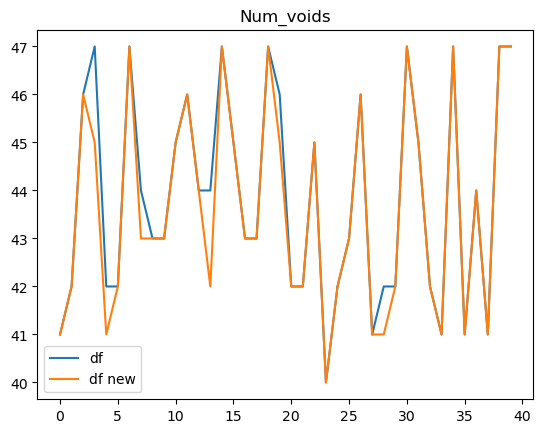

In [13]:
# they are equal almost
plt.plot(df_parts['Num_voids'], label='df')
plt.plot(df_new_parts['Num_voids'], label='df new')
plt.title("Num_voids")
plt.legend()
plt.show()

In [14]:
df_new_parts['Num_voids'] - df_parts['Num_voids']

0     0
1     0
2     0
3    -2
4    -1
5     0
6     0
7    -1
8     0
9     0
10    0
11    0
12    0
13   -2
14    0
15    0
16    0
17    0
18    0
19   -1
20    0
21    0
22    0
23    0
24    0
25    0
26    0
27    0
28   -1
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
Name: Num_voids, dtype: int64

## Comparison of columns in parts data

In [13]:
print(df_parts.shape)
print(df_new_parts.shape)
print()
print(df_voids.shape)
print(df_new_voids.shape)
print()
print(df.shape)
print(df_new.shape)

(40, 15)
(40, 18)

(1754, 15)
(1746, 18)

(1794, 15)
(1786, 18)


## View stored images

In [32]:
def compare_old_new_imgages(part_id):
	plt.figure(figsize=(8, 10))

	plt.subplot(2, 2, 1)
	# plt.subplot(1, 2, 1)
	# plt.subplot(1, 4, 1)
	img_old = plt.imread(genera_percorso_immagine(part_id, "originals","lab"))
	height, width = img_old.shape[:2]
	zoom_factor = 0.6
	zoomed_width = width * zoom_factor
	zoomed_height = height * zoom_factor
	x_center = width // 2
	y_center = height // 2
	x1 = max(0, x_center - zoomed_width // 2)
	x2 = min(width, x_center + zoomed_width // 2)
	y1 = max(0, y_center - zoomed_height // 2)
	y2 = min(height, y_center + zoomed_height // 2)
	plt.imshow(img_old, cmap="gray")
	plt.axis('off')
	plt.xlim(x1, x2)
	plt.ylim(y2, y1)
	# plt.suptitle(part_id_to_img_info(part_id))
	plt.title(f"img old (part_id={part_id}, nvoids={df_parts.iloc[part_id]['Num_voids']})")

	plt.subplot(2, 2, 2)
	# plt.subplot(1, 2, 2)
	# plt.subplot(1, 4, 2)
	img_new = plt.imread(genera_percorso_immagine(part_id, "rot&crop","lab"))
	height, width = img_new.shape[:2]
	zoom_factor = 0.8 
	zoomed_width = width * zoom_factor
	zoomed_height = height * zoom_factor
	x_center = width // 2
	y_center = height // 2
	x1 = max(0, x_center - zoomed_width // 2)
	x2 = min(width, x_center + zoomed_width // 2)
	y1 = max(0, y_center - zoomed_height // 2)
	y2 = min(height, y_center + zoomed_height // 2)
	plt.imshow(img_new, cmap="gray")
	plt.axis('off')
	plt.xlim(x1, x2)
	plt.ylim(y2, y1)
	plt.title(f"img new (part_id {part_id}, nvoids={df_new_parts.iloc[part_id]['Num_voids']})")

	plt.subplot(2, 2, 3)
	# plt.subplot(1, 4, 3)
	img_old = plt.imread(genera_percorso_immagine(part_id, "originals","seg"))
	plt.imshow(img_old,cmap="gray")
	plt.title(f"img old (part_id={part_id}, nvoids={df_parts.iloc[part_id]['Num_voids']})")
	plt.axis("off")

	plt.subplot(2, 2, 4)
	# plt.subplot(1, 4, 4)
	img_new = plt.imread(genera_percorso_immagine(part_id, "rot&crop","seg"))
	plt.imshow(img_new,cmap="gray")
	plt.title(f"img new (part_id {part_id}, nvoids={df_new_parts.iloc[part_id]['Num_voids']})")
	plt.axis("off")

	plt.tight_layout()
	plt.show()

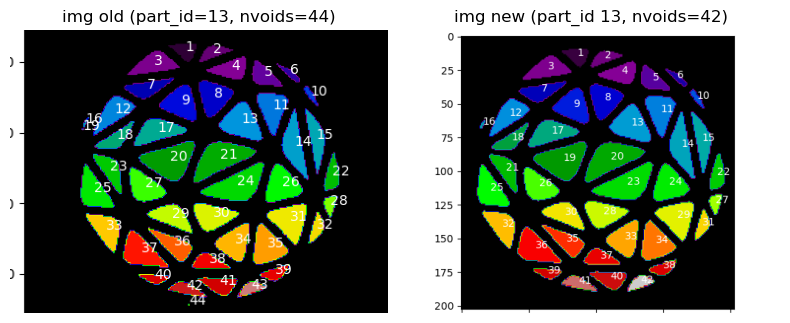

In [30]:
part_id = random.randint(0, 39)
part_id = 13
compare_old_new_imgages(part_id)

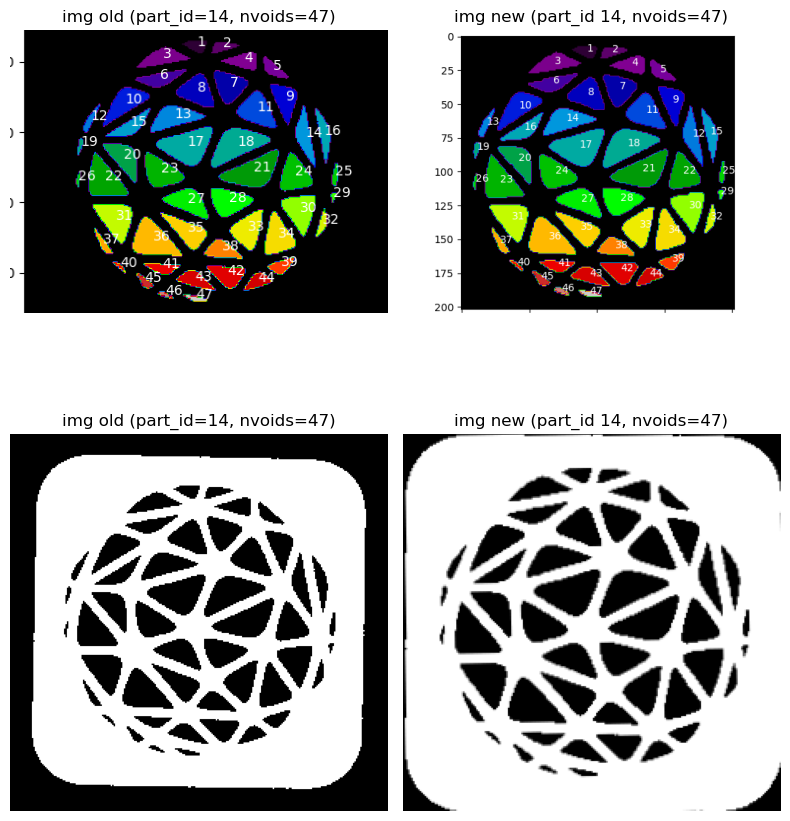

In [35]:
compare_old_new_imgages(14)

# Add more new variables

In [77]:
def count_pixels(pid):
	# same code of the df_new generation procedure
	image_path = genera_percorso_immagine(pid, "rot&crop")
	image = Image.open(image_path)
	image = image.convert('L')
	enhancer = ImageEnhance.Contrast(image)
	image = enhancer.enhance(100)
	image = np.array(image)
	otsu_thresh = threshold_otsu(image)
	image = image > otsu_thresh

	shape = np.shape(image)
	num_white_pixels = np.sum(image)
	num_black_pixels = (image == 0).sum()

	assert num_white_pixels + num_black_pixels == shape[0] * shape[1]
	return num_white_pixels, num_black_pixels

def pixels_ratio(pid):
	# we return #white pixels / #tot image pixels
	white_pixels = count_pixels(pid)[0]
	image_path = genera_percorso_immagine(pid, "rot&crop")
	image = Image.open(image_path)
	shape = np.shape(image)
	tot_pixels = shape[0]*shape[1]
	return white_pixels/tot_pixels

In [78]:
print(count_pixels(1))
print(pixels_ratio(1))

(37887, 14096)
0.7288344266394783


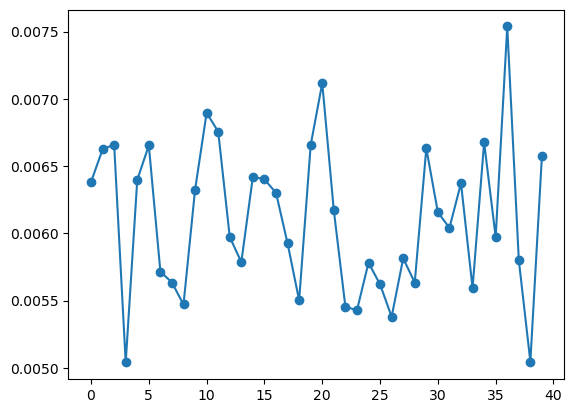

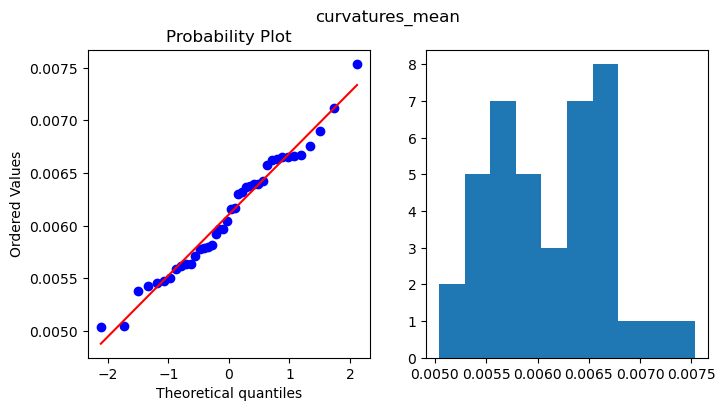

(curvatures_mean) P-value of normality: 0.5501565337181091 - normality (alpha 5%)? True


In [307]:
# example about how it works
curvatures_mean = np.zeros(40)

# part_id = random.randint(0,40)
for part_id in range(40):

	img = cv2.imread(genera_percorso_immagine(part_id, "originals"))

	# Converti l'immagine in scala di grigi
	gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

	# Applica la binarizzazione Otsu
	(T, threshInv) = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
	# (T, threshInv) = cv2.threshold(blurred_img, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)

	# Apply the Canny filter to detect edges
	edged = cv2.Canny(threshInv, 30, 200)
	# Find the contours
	contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)

	# Select the biggest contour
	largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	img_with_contours = img.copy()

	# crop the pictures following the biggest contour
	for i, contours in enumerate (largest_contours):
		# if i % 2 == 0:
			rect = cv2.minAreaRect(contours)
			box = cv2.boxPoints(rect)
			box = np.int0(box)
			# print(f"Angle here is {rect[2]}")
			cropped_image, rot_image = rotate_and_crop(img, rect, verbose=0)
			# print(f"Angle in df was {df.loc[part_id, 'Orientation [radians]']} radians, ie {math.degrees(df.loc[part_id, 'Orientation [radians]'])} degrees")
			# cropped_images.append(cropped_image)                
			# cropped_filename = os.path.splitext(filename)[0] + "_crp{}.jpg".format(i+1)

			edged = cv2.Canny(rot_image, 30, 200)
			# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_L1)
			# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
			contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE )
			# contours, hierarchy = cv2.findContours(edged, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE )
			largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]

	# reconnect end with begin points
	contours_points = np.append(largest_contours[0][:, 0], [largest_contours[0][:, 0][0]], axis=0)
	# try to emulate a defected piece
	# if part_id==12:
	# 	contours_points = np.append(largest_contours[0][:, 0], [[170,10],largest_contours[0][:, 0][0]], axis=0)
	# else:
	# 	contours_points = np.append(largest_contours[0][:, 0], [largest_contours[0][:, 0][0]], axis=0)

	x_coords = [point[0] for point in contours_points]
	y_coords = [point[1] for point in contours_points]
	curvature = calculate_curvature(contours_points)

	# curvatures_mean[part_id] = np.max(np.abs(curvature))+np.mean(curvature)
	curvatures_mean[part_id] = np.mean(curvature)

plt.plot(curvatures_mean,'o-')
plt.show()

summary_gaussianity(curvatures_mean,"curvatures_mean")
# no problems with curvatures_mean gaussianity so no need to transform with log
# summary_gaussianity(np.log(curvatures_mean),"log(curvatures_mean)")
# summary_gaussianity(curvatures_min,"curvatures_min")

df_new_parts["Curvature Mean"] = curvatures_mean

In [308]:
# df_new_parts = df_new_parts.drop(columns=["log(curvature max)"])
df_new_parts.head()

Image name      Position Region type  ID  Area [pixels]  Perimeter [pixels]  \
0  img01.bmp      top_left        part   0          38291            4105.674   
1  img01.bmp   bottom_left        part   0          37887            4155.306   
2  img01.bmp     top_right        part   0          37334            4106.076   
3  img01.bmp  bottom_right        part   0          37868            4139.319   
4  img02.bmp      top_left        part   0          36599            4223.005   

   Eccentricity  Orientation [radians]  Solidity  Extent  \
0         0.153                 -1.268     0.760   0.743   
1         0.157                 -1.304     0.752   0.735   
2         0.189                  1.564     0.752   0.734   
3         0.164                 -1.070     0.756   0.738   
4         0.118                 -0.817     0.730   0.713   

   Major Axis Length [pixels]  Minor Axis Length [pixels]  \
0                     277.925                     274.667   
1                     279.026                     275.584   
2                     277.777                     272.791   
3                     277.900                     274.158   
4                     280.140                     278.182   

   Equivalent Diameter [pixels]  Part_ID  Num_voids  Num_Wpixels  Num_Bpixels  \
0                       220.802        0         41        38291        13692   
1                       219.634        1         42        37887        14096   
2                       218.026        2         46        37334        14194   
3                       219.579        3         45        37868        13661   
4                       215.869        4         41        36599        15385   

   Wpixels_ratio  Curvature Mean  
0       0.736606        0.006382  
1       0.728834        0.006624  
2       0.724538        0.006660  
3       0.734887        0.005039  
4       0.704044        0.006398

In [79]:
df_new_parts['Num_Wpixels'] = df_new_parts['Part_ID'].apply(lambda x: count_pixels(x)[0])
df_new_parts['Num_Bpixels'] = df_new_parts['Part_ID'].apply(lambda x: count_pixels(x)[1])
df_new_parts['Wpixels_ratio'] = df_new_parts['Part_ID'].apply(lambda x: pixels_ratio(x))

df_new_voids['Num_Wpixels'] = df_new_voids['Part_ID'].apply(lambda x: count_pixels(x)[0])
df_new_voids['Num_Bpixels'] = df_new_voids['Part_ID'].apply(lambda x: count_pixels(x)[1])
df_new_voids['Wpixels_ratio'] = df_new_voids['Part_ID'].apply(lambda x: pixels_ratio(x))

In [86]:
df_new['Num_Wpixels'] = df_new['Part_ID'].apply(lambda x: count_pixels(x)[0])
df_new['Num_Bpixels'] = df_new['Part_ID'].apply(lambda x: count_pixels(x)[1])
df_new['Wpixels_ratio'] = df_new['Part_ID'].apply(lambda x: pixels_ratio(x))


In [309]:
# save
df_new.to_csv('../Processed dataset/df_new.csv', index=False)
df_new_parts.to_csv('../Processed dataset/df_new_parts.csv', index=False)
df_new_voids.to_csv('../Processed dataset/df_new_voids.csv', index=False)

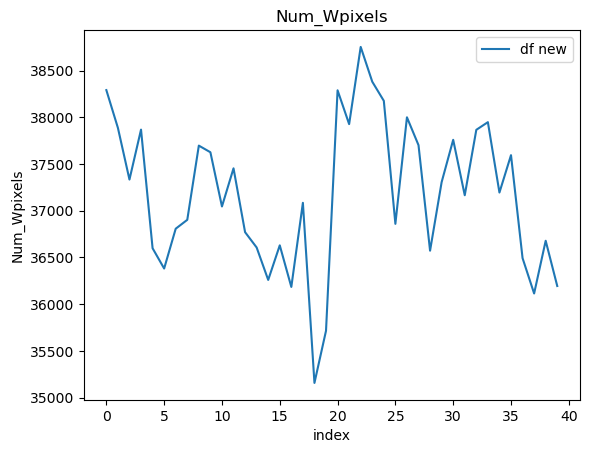

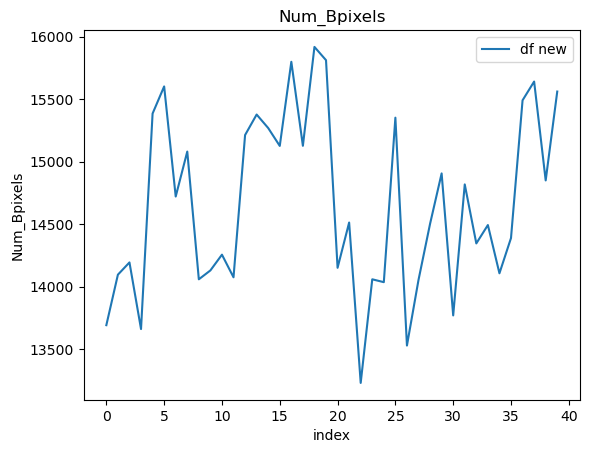

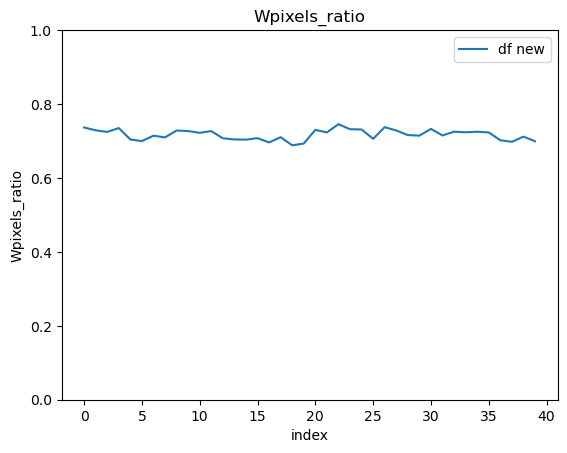

In [89]:
for column in df_new_parts.columns[15:]:
	# Traccia la colonna corrente di df rispetto alla corrispondente colonna di df_new
	plt.plot(df_new_parts[column], label='df new')
	# Aggiungi titolo, etichette degli assi e legenda
	plt.title(column)
	plt.xlabel('index')
	plt.ylabel(column)
	plt.legend()
	if column=="Wpixels_ratio":
		plt.ylim(0,1)

	# Mostra il grafico per questa coppia di colonne
	plt.show()